# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to build the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize

import data as d
import likelihood as l
import plots as p
import clustering as c

import emcee
from pyDOE import lhs

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf
import GPy
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from scipy.stats.distributions import norm
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [3]:
# For the clustering, we look around objects with mass greater than this and
# count objects in the 0.1 dex smaller than it.
cen_sat_div = [11.65, 11.75, 11.85]

# [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
# ^ Were the results from the very long run with ... some config (I don't really remember...)
# But I now needed to restart to get memory.

# See the appendix A for how we got these starting params
b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
s_params = [-0.1, 0.5]
params = b_params + s_params
x_field = "Vmax@Mpeak"

# To speed things up we store a previous best_fit
best_fit = params = [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]

In [4]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["halo_mvir"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning:Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.


# Find bestfit to SMF with optimizer

In [ ]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 3),
    method="Nelder-Mead",
)
assert res.success == True
best_fit = res.x

[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 2.047974372516754
[ 2.49898412 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 287.4558895771229
[ 2.37998488 11.46644418  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 932694.4411151003
[ 2.37998488 10.92042303  0.37404905  0.18581664  0.27877097 -0.11090357  0.51954824] 2.9115744045057492
[ 2.37998488 10.92042303  0.35623719  0.19510747  0.27877097 -0.11090357  0.51954824] 2.905680652491643
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.29270952 -0.11090357  0.51954824] 2.2966063655056312
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11644875  0.51954824] 22.936216957802213
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.54552565] 113.510966372972
[ 2.41398466 10.37440188  0.36132629  0.18847116  0.28275341 -0.11248791  0.52697036] 

# MCMC

## GP training

In [5]:
ranges = np.array([
    [2.3, 2.5],
    [10.75, 11.15],
    [0.3, 0.4],
    [0.12, 0.25],
    [0.2, 0.4],
    [-0.13, -0.08],
    [0.4, 0.6],
])

samples = ranges[:,0] + (ranges[:,1] - ranges[:,0]) * lhs(len(ranges), samples=10000)
#samples = np.append(samples, np.ones((len(samples), 2)) * np.array([best_fit[-2], best_fit[-1]]), axis=1)

In [29]:
def f(params):
    np.random.seed() # Required else workers share state.
    return l.compute_chi2_n(params, sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 1)

with Pool(6) as p:
    chi2 = p.map(f, samples)
chi2 = np.array(chi2)

# 6 in 15s, 25 in 1m, 1500 in 1h, 10 000 overnight!

[ 2.43714293 10.79193118  0.35533016  0.17739347  0.21770822 -0.12305287  0.4261341 ] 496.65303289475696
[ 2.40845283 10.86936171  0.37060241  0.21890866  0.22606016 -0.10597898  0.55104883] 10.221094679426736
[ 2.49320641 11.06660833  0.35968898  0.22841454  0.26547649 -0.12619271  0.42894675] 626.2097664934126
[ 2.42903199 10.85409446  0.35252028  0.1518713   0.30561363 -0.10138132  0.41797307] 497.3758608237206
[ 2.36122162 10.77489545  0.36772862  0.23390095  0.32381501 -0.10289661  0.5101132 ] 226.68171125316724
[ 2.36972793 10.75970464  0.33854009  0.14928868  0.23949813 -0.10056542  0.52928959] 41.24162387673054
[ 2.38895192 10.7863813   0.39574862  0.21313692  0.2318289  -0.08317392  0.4066984 ] 419.14548123890495
[ 2.49089715 11.130163    0.30408953  0.12476504  0.26305517 -0.12944528  0.52926398] 253.36597035028007
[ 2.47815548 10.80529171  0.33592656  0.1389213   0.36384589 -0.12371523  0.46008335] 438.15102099038376
[ 2.42520679 10.87950185  0.30849619  0.14589084  0.391134

[ 2.32782679 10.94116961  0.35218337  0.15315586  0.30756145 -0.11966722  0.44720944] 131.45977905460143
[ 2.36229561 11.03287917  0.35575325  0.13575829  0.28854955 -0.08164075  0.58408066] 108570.24668999278
[ 2.37165858 10.85995915  0.35064212  0.16213699  0.39654213 -0.11596711  0.50474126] 241.92180759891644
[ 2.46117967 11.08203146  0.36593438  0.12734178  0.38276065 -0.10035798  0.42003735] 123.37660739218836
[ 2.3663979  11.01306782  0.32317269  0.19228735  0.36721033 -0.08622997  0.58019502] 47849.16937430418
[ 2.46294146 11.08965249  0.39775261  0.24522188  0.21158806 -0.10219264  0.40593733] 365.2852638902944
[ 2.42329716 10.83187141  0.37871348  0.15074036  0.21144451 -0.11842883  0.41160179] 542.720134712848
[ 2.36081452 11.03502704  0.33982996  0.18081125  0.34286062 -0.08114391  0.47710093] 4715.805037626158
[ 2.42563817 10.90877572  0.37136334  0.14890894  0.2829043  -0.0805071   0.55952854] 2862.8451100080283
[ 2.36643367 10.89783512  0.3837096   0.16612459  0.20345479

[ 2.44083633 10.9179915   0.37061725  0.22557072  0.36133049 -0.10884126  0.56611768] 27.94691265938623
[ 2.33222394 10.82605154  0.34753471  0.14320143  0.36103345 -0.08025497  0.42151595] 91.32727784898105
[ 2.30747552 10.86995904  0.30938055  0.22711056  0.301373   -0.09727059  0.52140079] 591.2220041814898
[ 2.34942755 10.77411212  0.33361354  0.20013288  0.24143669 -0.10448991  0.55257968] 13.639784775844532
[ 2.30814364 11.05856568  0.39811671  0.15573918  0.26210357 -0.1290577   0.53373528] 4996.621887287658
[ 2.37252678 10.77088833  0.32737111  0.22076159  0.24239144 -0.12205915  0.56007588] 190.80182617175265
[ 2.49217945 10.93331227  0.30965789  0.18138217  0.20730111 -0.09190586  0.53565336] 60.77163480128332
[ 2.48942325 11.084497    0.37770144  0.21835168  0.30315347 -0.09449586  0.53065449] 920.0479554837902
[ 2.37122854 10.87111162  0.37796039  0.13270838  0.295097   -0.10742773  0.53720694] 46.25132739853284
[ 2.43168987 10.80381637  0.37967801  0.13812688  0.26702584 -

[ 2.33482925 10.83480627  0.32122295  0.17513535  0.27785562 -0.09112645  0.52731944] 623.9114047424608
[ 2.40186903 10.79947531  0.36524832  0.21284928  0.36484956 -0.09657174  0.49226913] 268.88343181861893
[ 2.37235802 10.96240945  0.3905384   0.20271657  0.34135719 -0.09161134  0.40692757] 248.0524591112615
[ 2.36777488 10.92772265  0.38674917  0.14539427  0.38556876 -0.10842354  0.40786496] 580.5922024454159
[ 2.3562053  11.1050251   0.36229668  0.21297043  0.28650614 -0.09157124  0.48730336] 10085.46354198381
[ 2.44187353 11.10592189  0.36532853  0.23011278  0.32490008 -0.11651697  0.52933205] 417.64132210821924
[ 2.45066865 10.79175336  0.38725746  0.24573165  0.25556973 -0.10343852  0.48277376] 401.4332139336153
[ 2.34503322 11.0481551   0.32967075  0.12419642  0.35563348 -0.0886398   0.53757239] 38829.17899986146
[ 2.42638775 11.11673126  0.39344658  0.15227911  0.37845684 -0.08396535  0.58175847] 86921.06662550021
[ 2.33470619 10.95489411  0.35772621  0.13590901  0.32978512 -

[ 2.39795163 11.03297078  0.30708602  0.15424645  0.34307157 -0.11981024  0.49950827] 89.42924592946764
[ 2.42542633 10.77553557  0.33835991  0.15106183  0.27398514 -0.10562896  0.4935361 ] 388.7747019076932
[ 2.34534636 10.91413467  0.33812106  0.12845188  0.25018378 -0.10540865  0.42516312] 50.205520047471076
[ 2.34912973 11.13238228  0.35282934  0.14531331  0.26041086 -0.10097039  0.52993662] 47561.94072864124
[ 2.31996553 10.93417716  0.32595602  0.229586    0.36332356 -0.09498973  0.57146206] 13610.714684496232
[ 2.30108195 10.99448246  0.35666324  0.16305773  0.29468658 -0.10513444  0.59404371] 58896.61794515016
[ 2.31559817 10.94352095  0.30841131  0.24362946  0.37363099 -0.11630892  0.53227981] 316.7445945786253
[ 2.33337408 10.89207006  0.30127169  0.16959059  0.21922852 -0.09352589  0.50871951] 1718.2271502812264
[ 2.39679134 10.79742139  0.35118144  0.2093597   0.33156938 -0.09299011  0.52102994] 85.79298237894811
[ 2.48753798 11.0133187   0.3603529   0.17192804  0.34752502 

[ 2.40981187 11.05309735  0.3092471   0.19536956  0.22146031 -0.11695954  0.51406931] 406.7553112007038
[ 2.34398044 10.84849749  0.3659231   0.15014135  0.35107321 -0.088033    0.48326267] 12.569168950171765
[ 2.38962873 11.10207332  0.37281018  0.20439134  0.20012207 -0.12185516  0.54076706] 2885.67798749214
[ 2.35063213 10.82282478  0.37785827  0.17686763  0.30160958 -0.08178739  0.5316091 ] 732.4672191599598
[ 2.32855433 11.11956137  0.32213153  0.19832361  0.37033302 -0.08603154  0.49243405] 37646.69296410482
[ 2.43351745 10.78768598  0.3459239   0.19620042  0.24748212 -0.11934842  0.41204243] 487.2198087161661
[ 2.32082197 11.11583017  0.32869597  0.23372977  0.34597163 -0.09425119  0.4160134 ] 2134.3828395693668
[ 2.39906534 11.06721495  0.33406236  0.14640003  0.2461091  -0.12297394  0.59634212] 9738.668826532194
[ 2.40004421 10.82298556  0.30556757  0.20513653  0.30618729 -0.09003798  0.50910548] 42.65971114595289
[ 2.36913849 10.83164448  0.38976585  0.17332819  0.34923965 -0

[ 2.31546411 10.83031898  0.3887889   0.17662399  0.27735315 -0.1230112   0.51331983] 167.66975324484275
[ 2.30710407 10.94009555  0.36471922  0.20922608  0.39894779 -0.12957264  0.50337014] 124.98345598527463
[ 2.46806494 10.92189218  0.34894604  0.13278151  0.35252877 -0.11136691  0.51889014] 186.93359833071503
[ 2.35101445 11.07179851  0.36187936  0.19673022  0.30617325 -0.0810637   0.58546875] 208303.65666945378
[ 2.34295155 10.8704136   0.34408793  0.1466926   0.31771669 -0.08486812  0.56408327] 7975.673741191575
[ 2.35323479 10.96620665  0.30249322  0.17338382  0.22055283 -0.1067855   0.40526284] 56.64291250033642
[ 2.42809868 10.82129042  0.37503797  0.18414604  0.35420168 -0.098714    0.58209359] 72.79230442113563
[ 2.36247488 11.01135763  0.3093222   0.21542038  0.26410966 -0.11819286  0.40661144] 325.8549423034649
[ 2.47647233 10.84284267  0.30592053  0.12955458  0.21493446 -0.09942251  0.4812336 ] 305.8721041421167
[ 2.39338179 11.10285418  0.34119632  0.14772009  0.364147  

[ 2.46149727 11.09599149  0.34442838  0.18253758  0.31396428 -0.12345229  0.58755513] 1603.0864230540978
[ 2.45709439 10.75240969  0.37456474  0.18544039  0.28240083 -0.12337599  0.59685279] 270.3643535109867
[ 2.49410491 10.99920135  0.30074351  0.21101568  0.21258279 -0.08504849  0.4923439 ] 37.880180603351114
[ 2.31629261 10.874052    0.32436342  0.18970678  0.24172705 -0.1179034   0.49851079] 19.43087693117595
[ 2.34009309 10.92619166  0.39283094  0.24549553  0.25130808 -0.11656696  0.48263967] 171.4872545761795
[ 2.4638991  10.95800311  0.37668625  0.19581873  0.39120026 -0.11913534  0.44165526] 447.80427148035045
[ 2.3131675  11.03510682  0.30153305  0.21362909  0.3721163  -0.11213965  0.40039863] 134.07850415529867
[ 2.49879723 10.98414809  0.31845521  0.12328166  0.35296646 -0.12122565  0.42872157] 627.0867356573146
[ 2.42392362 11.03206439  0.34027758  0.24798137  0.39811127 -0.10865988  0.48912793] 32.39004215639437
[ 2.35585516 10.82341338  0.32648636  0.19729106  0.30791066

[ 2.46347622 10.95557514  0.31645608  0.21848611  0.2782672  -0.09270832  0.40946577] 458.2599313520397
[ 2.49821367 10.87092796  0.38098236  0.12651785  0.38444181 -0.1299101   0.43708643] 438.9668863601427
[ 2.3696398  10.9683718   0.33202035  0.23030037  0.23004832 -0.11015746  0.48684285] 10.568067511332568
[ 2.41550908 10.94923514  0.31492868  0.16968886  0.33750006 -0.10400043  0.43324056] 333.67755479847904
[ 2.43014091 10.86911063  0.32153831  0.19606218  0.25477735 -0.09395493  0.52700982] 19.51875112521093
[ 2.33258684 11.09932721  0.3681257   0.15810441  0.23017024 -0.08673551  0.45399463] 14304.50050242343
[ 2.31542166 11.08826915  0.34755222  0.19376896  0.27273472 -0.08631256  0.54668166] 135206.83056531262
[ 2.43645322 11.08398588  0.35726883  0.18899591  0.21651702 -0.12505121  0.52196146] 111.99744879310362
[ 2.40320117 10.87079669  0.31546532  0.2053933   0.32630678 -0.10448006  0.4418967 ] 453.2840300702709
[ 2.43143033 11.03076926  0.3602846   0.22292231  0.3747949 

[ 2.37826142 10.86349565  0.39568515  0.17954469  0.36553657 -0.08721527  0.48110652] 37.01504084485968
[ 2.36343666 10.85277105  0.3528107   0.18916     0.30594746 -0.12522107  0.40360171] 511.20386688367296
[ 2.38779257 10.87263105  0.33009196  0.14811817  0.26792242 -0.11618731  0.49346006] 178.0853040199412
[ 2.48682236 10.98727667  0.30846265  0.13996924  0.37763795 -0.10519516  0.4729518 ] 249.74476188669487
[ 2.41163875 11.0259201   0.32230597  0.20019985  0.26873388 -0.08781727  0.41252604] 19.345370077841324
[ 2.47819452 10.79384449  0.3594678   0.12266295  0.23115436 -0.08903885  0.5676476 ] 85.52171380092408
[ 2.31499728 10.78580842  0.32657639  0.23071983  0.32265743 -0.08254254  0.49628856] 32.71783220759635
[ 2.3129406  10.76572855  0.34202363  0.16559777  0.2141497  -0.08440087  0.4100196 ] 191.20364436056227
[ 2.3296781  11.10968213  0.38701809  0.17574533  0.26130469 -0.10157615  0.40818597] 1378.0993737805481
[ 2.40640558 11.05621725  0.33080189  0.19353891  0.2903799

[ 2.41059943 11.10678496  0.37375375  0.21778286  0.38807689 -0.09267981  0.57511763] 47627.08026675117
[ 2.49001191 10.90164891  0.36178785  0.19014412  0.21350498 -0.10733996  0.50462955] 334.2540615539717
[ 2.3066905  10.89304631  0.37341321  0.13112301  0.38982086 -0.12170714  0.57735039] 1283.972565961981
[ 2.38897856 10.75617014  0.32594672  0.16526162  0.20703781 -0.1285272   0.50290758] 533.0594992401224
[ 2.47807748 11.06393514  0.35681757  0.22989741  0.28965384 -0.11804556  0.43177203] 576.1309533046767
[ 2.44811169 11.07640023  0.39801744  0.12241338  0.2282267  -0.11675777  0.49711689] 90.32757775321276
[ 2.37158819 11.04469239  0.31998265  0.21723413  0.20152663 -0.10749119  0.49266693] 1047.0909122776297
[ 2.30723544 11.07384555  0.35314085  0.143949    0.29075268 -0.11820661  0.4769003 ] 4441.032307653835
[ 2.43911862 10.89725213  0.33535214  0.13026075  0.36703216 -0.11239871  0.49439282] 301.1989660058636
[ 2.33156438 10.75959996  0.30259887  0.21432645  0.2511242  -0

[ 2.47363771 10.99998117  0.33771424  0.17666279  0.20273145 -0.10259357  0.42341885] 356.7477234806606
[ 2.37285018 10.9283932   0.30929243  0.13356406  0.21324605 -0.11260625  0.56522326] 2768.7760840954134
[ 2.48013505 10.91596824  0.3698933   0.24061763  0.33186256 -0.11215249  0.45001771] 421.5197334016373
[ 2.4206936  10.82441081  0.36045703  0.24044629  0.32803025 -0.1206332   0.53902105] 326.8443898188625
[ 2.47280061 10.94094426  0.35372579  0.16445818  0.28001637 -0.12139633  0.45043465] 567.2405113449406
[ 2.35474197 11.11755634  0.32113642  0.15184211  0.23152614 -0.1122094   0.58167488] 69528.67553755119
[ 2.49447089 10.95625729  0.35481701  0.17166665  0.2800782  -0.12851899  0.47385343] 512.8473728871908
[ 2.32003883 11.12384407  0.30640037  0.17619976  0.23444381 -0.0974513   0.40245784] 7095.9003233034355
[ 2.38138923 11.09489678  0.3105782   0.20833493  0.36277948 -0.09104987  0.5422685 ] 27115.04332135566
[ 2.34958158 10.92152003  0.3381033   0.13089492  0.20718688 -

[ 2.38478335 10.75702859  0.32347186  0.12890763  0.25222844 -0.11108437  0.55773797] 53.887353298691195
[ 2.43889834 11.09501941  0.34132383  0.19691069  0.30782292 -0.09133932  0.51606359] 3547.629563826081
[ 2.49757549 11.07383644  0.32666526  0.21931471  0.35879358 -0.09596004  0.53990756] 684.0821385337783
[ 2.35435678 11.12021528  0.37892438  0.23691612  0.30952269 -0.08171135  0.59537113] 441566.6504210401
[ 2.36614047 10.83520087  0.36589456  0.1858935   0.33101925 -0.08997307  0.44119636] 264.8250943032393
[ 2.47776726 10.7665704   0.3038591   0.14041684  0.31862212 -0.12273918  0.44131796] 451.7282961990822
[ 2.43050852 11.04836448  0.38910298  0.19187303  0.25433697 -0.08376127  0.52180892] 4571.409323117801
[ 2.42063867 10.94056893  0.3331405   0.18864305  0.28171634 -0.10886991  0.55928156] 165.00903751502082
[ 2.34545069 10.76824382  0.33240975  0.14254293  0.32957223 -0.08585072  0.44841219] 165.9959923374349
[ 2.31651944 11.03066264  0.32047934  0.20930879  0.22045238 -

[ 2.33362906 10.91132149  0.35390502  0.22890165  0.37375807 -0.09828275  0.46101795] 65.24371722651753
[ 2.40524758 11.10136421  0.30992523  0.22813601  0.22539426 -0.10783446  0.55466408] 8773.066772231907
[ 2.30875912 10.95402038  0.32161179  0.19916093  0.32707601 -0.12425775  0.45069554] 196.89710796767318
[ 2.38995498 11.05017197  0.34189618  0.15770889  0.38435282 -0.11841178  0.47962524] 38.60445839237718
[ 2.35807629 11.12527315  0.34690985  0.16476645  0.39434844 -0.12726276  0.44737881] 278.83573204326854
[ 2.3770068  10.99011369  0.36264599  0.19941231  0.38493264 -0.09013542  0.59459795] 35156.790581523186
[ 2.45142522 10.88846484  0.39772565  0.17736145  0.21711098 -0.09941485  0.59290513] 485.42144737477105
[ 2.34053869 10.80579496  0.34780411  0.20461715  0.35365728 -0.08611029  0.42840154] 308.04704456788943
[ 2.41445786 10.80085154  0.3130295   0.16764     0.26975041 -0.11893141  0.5816842 ] 66.59139057963213
[ 2.31633248 11.10326554  0.34180064  0.22000746  0.2144792

[ 2.37911935 11.04692515  0.38598293  0.15359132  0.28047709 -0.09256463  0.5746291 ] 37542.14428850403
[ 2.33119821 10.87904209  0.35890286  0.19784331  0.3008874  -0.09749647  0.52093634] 313.7786703338366
[ 2.49084291 10.88267462  0.36806231  0.1465422   0.24215628 -0.09224799  0.55071313] 47.26946149650469
[ 2.49400153 10.79548871  0.36994004  0.24323663  0.31350266 -0.10560647  0.541631  ] 325.9039415201701
[ 2.44587364 10.93833134  0.31556351  0.12135101  0.20249799 -0.09033092  0.55109922] 2039.9056170028935
[ 2.45957426 11.04139151  0.36373837  0.24291176  0.21214213 -0.12089915  0.51622285] 57.68389998720565
[ 2.45891397 11.1169641   0.39783124  0.13531278  0.31734151 -0.11470978  0.43982332] 97.57938336674553
[ 2.3839164  11.06707935  0.38691237  0.20154614  0.32090075 -0.11854308  0.40630905] 458.5353470063137
[ 2.49420095 10.98351851  0.36506321  0.18387855  0.23540308 -0.09752942  0.49202503] 86.07758513886934
[ 2.30561211 10.97458234  0.34642921  0.14344164  0.25516646 -0

[ 2.39103867 11.03523364  0.35749292  0.15802865  0.25062574 -0.11127819  0.56206217] 4797.8428964362765
[ 2.46200973 10.80166903  0.30034168  0.12720562  0.28622056 -0.10951337  0.47113935] 491.0243386248585
[ 2.31471053 10.86194005  0.38810377  0.15809605  0.3864772  -0.12861153  0.45239939] 613.8198554325941
[ 2.4641485  10.98238414  0.34308627  0.24541318  0.3442875  -0.10666046  0.45401274] 409.20507914700397
[ 2.3995308  10.94704897  0.30115857  0.20517046  0.38573811 -0.10143175  0.51798788] 44.052971837986384
[ 2.36356067 10.85737055  0.33973827  0.19446138  0.2661587  -0.12460724  0.40098864] 600.7111041265377
[ 2.38112243 10.92394649  0.34739456  0.13500315  0.39199106 -0.09911772  0.46330694] 49.531778760401025
[ 2.44914993 11.05983413  0.30046889  0.18444019  0.27438846 -0.08841664  0.44759622] 94.04614667661347
[ 2.40772296 10.83797295  0.37448995  0.23084378  0.26330664 -0.0951739   0.52892849] 41.746567291834985
[ 2.44231821 10.89314409  0.35957978  0.13835442  0.2351802

[ 2.37755682 11.02343161  0.37259835  0.14004327  0.33411124 -0.09346221  0.47630763] 904.7691079868199
[ 2.35287961 11.13642875  0.3960645   0.18649528  0.34611544 -0.12402707  0.56662694] 19952.038411627007
[ 2.43742201 10.92074282  0.36315443  0.20216052  0.29713223 -0.10345038  0.42803842] 470.4442792070905
[ 2.48209906 10.98157357  0.37614649  0.18060492  0.39071047 -0.12496178  0.58225111] 22.056771193540026
[ 2.40183372 10.82216614  0.36048679  0.16733141  0.20533725 -0.08393395  0.56988366] 1315.678480608411
[ 2.40060996 11.05895244  0.39773322  0.24915163  0.36269531 -0.08626973  0.52906786] 10188.898613554724
[ 2.38213391 10.84803556  0.3256808   0.18353326  0.25706621 -0.10210761  0.43802351] 401.5807989237892
[ 2.49679988 10.97691026  0.39026048  0.1621111   0.35766455 -0.10624449  0.52378791] 89.86488570294463
[ 2.48128057 11.06783148  0.3525657   0.14056128  0.3829601  -0.09925817  0.40342326] 374.05790970767237
[ 2.46943938 10.84826037  0.36715997  0.2298324   0.22105998

[ 2.34846113 10.893742    0.31624252  0.13324575  0.22373317 -0.11541574  0.46058156] 46.582733780593
[ 2.38487353 11.01141801  0.38809926  0.12897271  0.32880116 -0.08398456  0.52774129] 9325.288129204977
[ 2.37908088 10.97758724  0.39864989  0.17063769  0.26564621 -0.10280131  0.49461233] 104.3604797460129
[ 2.30070896 11.12366802  0.38533668  0.20808369  0.30130895 -0.08951324  0.59285609] 631254.0945867039
[ 2.43353542 10.90312517  0.37922955  0.14361027  0.28217909 -0.09680507  0.5165704 ] 13.124356799363468
[ 2.3276448  10.83332696  0.32912153  0.19622201  0.28601936 -0.08839865  0.44786609] 58.66333674099539
[ 2.41418787 10.88663735  0.36101785  0.23196274  0.26316807 -0.11599548  0.5867496 ] 35.042491060214566
[ 2.34601096 11.11530855  0.38652923  0.21611491  0.23472813 -0.12813569  0.41343461] 161.09641486550777
[ 2.33973361 11.0842643   0.36660111  0.21528284  0.20910711 -0.11262108  0.54186631] 13260.68438305551
[ 2.46004964 11.05116351  0.38881816  0.17320367  0.31189037 -0

[ 2.43537651 11.01746217  0.36170936  0.18350778  0.35304286 -0.08345251  0.49568477] 667.1992759299161
[ 2.36171677 10.75660062  0.31982231  0.18321045  0.34935472 -0.11020337  0.55973219] 69.00200775732516
[ 2.48126098 10.85552293  0.36093906  0.12073352  0.30190828 -0.08562955  0.54065604] 55.44101963681606
[ 2.37453589 11.01445547  0.30612596  0.21966946  0.23546944 -0.09540804  0.52921463] 4872.066255732885
[ 2.40840552 10.84652672  0.3368774   0.1853458   0.32757561 -0.08331388  0.4996469 ] 20.57245588985709
[ 2.33987221 11.13192698  0.31716047  0.21960705  0.28433733 -0.08898194  0.41695208] 4345.330502430819
[ 2.46864787 10.85364351  0.34351499  0.17324103  0.26382568 -0.1043012   0.48950985] 377.05125852372447
[ 2.34856026 10.81845967  0.36228774  0.19090141  0.28669472 -0.12198541  0.43862178] 528.6075739374967
[ 2.3847559  11.10063027  0.31347481  0.18792877  0.26781775 -0.10384475  0.51222749] 6059.124212142917
[ 2.48805364 11.03911809  0.33844496  0.12992171  0.29816635 -0

[ 2.32849783 11.00671206  0.39888977  0.21565102  0.29164442 -0.09109165  0.41048781] 35.94595981032749
[ 2.30528147 10.86251416  0.3257645   0.19959827  0.3960464  -0.11418965  0.45019267] 407.1094490487117
[ 2.44368723 10.87285618  0.38876428  0.19250515  0.2730578  -0.09786151  0.56884456] 83.97167615686362
[ 2.45484473 11.01162211  0.36698645  0.16713593  0.33297424 -0.08223673  0.48503378] 200.0802507935637
[ 2.37824296 11.0910164   0.38770148  0.1869141   0.31312587 -0.09821324  0.55330667] 24248.783930876027
[ 2.35957258 11.01388538  0.32606854  0.16438949  0.37302259 -0.10412496  0.51822494] 2100.717849653094
[ 2.30861159 11.06459608  0.36778495  0.13194939  0.22697431 -0.0922873   0.41594795] 6482.037421074852
[ 2.47218951 10.86472002  0.37144096  0.24314795  0.23225821 -0.11021482  0.54014784] 230.03615628235508
[ 2.44330886 11.05437305  0.30440216  0.24082727  0.34009204 -0.0801123   0.41107202] 18.38994527343363
[ 2.34895012 11.01981475  0.39861577  0.22591038  0.28131728 -

[ 2.31833435 11.14771666  0.35843065  0.13787886  0.32013948 -0.11951517  0.40329127] 2909.2970988086795
[ 2.43081399 10.81825202  0.33523912  0.21525771  0.28562325 -0.12331584  0.55902011] 268.74585874714563
[ 2.35885197 10.94933453  0.30741253  0.12344021  0.26837304 -0.08108702  0.48218522] 4273.6794866713935
[ 2.32772101 11.09962764  0.34936938  0.17843794  0.29646723 -0.08195372  0.42285555] 6843.930960508111
[ 2.32092838 11.02590877  0.32080062  0.12871362  0.36667002 -0.11490412  0.55733413] 14357.538867340765
[ 2.40668557 10.87006439  0.37038817  0.1969883   0.39903389 -0.11413414  0.4005096 ] 485.0376204603962
[ 2.49057078 11.14085454  0.39507861  0.13724837  0.28834258 -0.09033958  0.57730315] 20637.804004798978
[ 2.49765003 10.79868547  0.30052552  0.17581672  0.37265894 -0.1245819   0.52719379] 413.42085098594225
[ 2.3926755  10.79589342  0.36037493  0.16522199  0.39374073 -0.09894075  0.41297376] 448.7724210545264
[ 2.46773355 10.76855652  0.34798217  0.16697246  0.344306

[ 2.35173584 11.13428293  0.34856192  0.23008505  0.25899542 -0.09797707  0.4577218 ] 4977.882853555917
[ 2.36734209 10.96988136  0.38276849  0.20547456  0.359076   -0.08834966  0.52510927] 2988.267261514869
[ 2.40030379 10.99876748  0.33440232  0.14908324  0.33920796 -0.1013354   0.41348574] 153.42186334061975
[ 2.35302405 10.95668575  0.32325732  0.14234669  0.33814512 -0.08870835  0.58011307] 28920.93220939444
[ 2.45321739 10.97862365  0.33416288  0.23727267  0.26839297 -0.11534493  0.50168739] 211.9346139074214
[ 2.4400071  11.14874575  0.35623149  0.23082803  0.25242311 -0.12077409  0.51556946] 584.4691591646899
[ 2.32934954 10.94037642  0.32989279  0.16227264  0.21384555 -0.11870304  0.54200446] 1602.9606264763036
[ 2.41204065 10.79695101  0.38549475  0.23777986  0.35336183 -0.11655341  0.54139574] 305.7486676129264
[ 2.32826505 10.84845443  0.35675758  0.17343192  0.24800289 -0.12480113  0.46445932] 467.22084938822695
[ 2.33139413 10.95610808  0.37465447  0.12554109  0.27281182 

[ 2.48956923 10.75659503  0.35900288  0.2043161   0.25658237 -0.10665979  0.4641974 ] 473.9075505193563
[ 2.3443472  11.0404517   0.36010531  0.24905888  0.34509407 -0.08986368  0.52825838] 15616.720901266974
[ 2.36204475 10.82905698  0.38883912  0.16315627  0.38011373 -0.12335386  0.56431916] 73.55039456236867
[ 2.448896   10.81412424  0.36361637  0.19579734  0.29308753 -0.11578213  0.40756307] 473.6951453698618
[ 2.4488439  11.08379778  0.34297379  0.23645204  0.35149134 -0.1286887   0.5755998 ] 427.114791408255
[ 2.33927604 11.10081778  0.31946616  0.16200466  0.28611482 -0.10609564  0.58046494] 87565.41381428718
[ 2.38326286 10.8267082   0.35550363  0.17552943  0.27798619 -0.08525653  0.56428223] 1242.9698055216377
[ 2.30854219 11.1466683   0.37890113  0.13238982  0.32347837 -0.11533233  0.59950511] 249024.57913149492
[ 2.38980062 11.11847911  0.3845323   0.19325861  0.22399627 -0.11456518  0.50006009] 1804.2895018827194
[ 2.49752106 11.05903307  0.3020162   0.22008152  0.32110733 

[ 2.36078127 10.92080825  0.36784679  0.18877576  0.35122427 -0.12145814  0.48637826] 276.07413681900846
[ 2.34929374 11.00773921  0.39826612  0.24732843  0.24778964 -0.10030336  0.44678791] 27.65171529535983
[ 2.43754465 11.12698785  0.38841228  0.14614097  0.21971417 -0.09137013  0.40893393] 249.5320283728314
[ 2.36646945 10.80707113  0.36273194  0.1464707   0.34942404 -0.09375592  0.58631547] 1399.0567498378484
[ 2.38403503 10.83472242  0.30215242  0.13905649  0.36189202 -0.08280696  0.48559045] 24.35458764885085
[ 2.35162792 10.84924654  0.35858486  0.18122421  0.34269471 -0.09840816  0.47997363] 87.03577094753305
[ 2.37896659 11.09304044  0.38825192  0.13032302  0.38170173 -0.09454992  0.47208982] 2761.9711287920454
[ 2.30203247 10.89703185  0.32883604  0.21054998  0.20833016 -0.09701929  0.47026569] 211.82067235657996
[ 2.43078015 11.00026409  0.31928296  0.20352441  0.28981873 -0.11333658  0.4807496 ] 118.33544375697917
[ 2.41836484 11.09658242  0.35754118  0.15992946  0.3878062

[ 2.34230752 10.91385781  0.32286249  0.15697829  0.34765895 -0.11042303  0.47097637] 45.06545725378523
[ 2.45237922 10.88881711  0.30567243  0.18215722  0.35867119 -0.12186039  0.45835343] 506.83430576982335
[ 2.43026258 10.83576783  0.38954529  0.13649608  0.26959187 -0.09968486  0.4220239 ] 477.35003500727225
[ 2.48588038 10.864351    0.33933311  0.13116658  0.32650762 -0.11037661  0.44557769] 483.55546106217344
[ 2.33236653 10.98577611  0.306479    0.17170493  0.34645225 -0.10491464  0.59320374] 27865.297193758634
[ 2.44284877 10.79437284  0.37932529  0.20843205  0.21894311 -0.09451832  0.59869907] 174.45420373531317
[ 2.31539486 10.91833382  0.3925481   0.1302077   0.32023757 -0.08585565  0.46906161] 854.8808830654868
[ 2.48310237 10.85536598  0.32174825  0.13675288  0.31148227 -0.11857557  0.46266346] 510.90940879401705
[ 2.45610428 10.88711363  0.39879962  0.19048905  0.39513571 -0.09561561  0.47673843] 294.8296605703613
[ 2.3585281  10.95894511  0.33839694  0.23964138  0.229006

[ 2.34460947 10.89270579  0.3680819   0.1962562   0.26652012 -0.08973109  0.57565358] 8919.335838162937
[ 2.48035857 10.99526773  0.36959323  0.17098709  0.35408743 -0.12172266  0.5550997 ] 45.28275684543554
[ 2.36801111 10.97527809  0.32192084  0.18183792  0.22174234 -0.10475108  0.59514345] 14471.357477694442
[ 2.3602985  11.03560097  0.33624426  0.12210018  0.39540126 -0.12829339  0.41830884] 134.71267670586727
[ 2.39323275 10.84953852  0.30725042  0.21343846  0.3698525  -0.12235681  0.53281176] 251.2401989415757
[ 2.47258043 10.92794093  0.36425815  0.1997945   0.26228836 -0.11887476  0.55090463] 137.49646109494992
[ 2.32446704 10.94943751  0.33068325  0.19577353  0.29766466 -0.10814555  0.40925097] 238.36500622983831
[ 2.47793879 10.95412334  0.30069373  0.13095723  0.31827633 -0.08156977  0.44739331] 77.5815828124581
[ 2.44176946 10.76866225  0.37540846  0.22113832  0.27052713 -0.10670745  0.53780112] 291.1895642430786
[ 2.42223299 10.91642751  0.30686358  0.13974281  0.34305913 

[ 2.33829374 11.08982719  0.34272107  0.23689196  0.3278348  -0.11846212  0.41729544] 146.7337942785319
[ 2.3061356  10.85938305  0.32894222  0.19455988  0.3692821  -0.08949233  0.50851931] 603.8705234782432
[ 2.40128677 11.07752628  0.33578419  0.22507157  0.34083081 -0.08841015  0.52941611] 11215.020864427248
[ 2.48076434 10.8148128   0.36359018  0.18532939  0.20459457 -0.08026451  0.57141273] 181.98738966313357
[ 2.32267925 10.78278096  0.33961896  0.15427084  0.3589423  -0.11219384  0.5195753 ] 92.56575352355497
[ 2.31849282 10.79553995  0.30698517  0.16365335  0.39376598 -0.10606857  0.43021659] 501.5184885001831
[ 2.34564034 10.77840174  0.31987376  0.22785545  0.28885217 -0.08335867  0.53486101] 221.46399171808383
[ 2.42848596 11.03774929  0.39648576  0.23254176  0.39509618 -0.10052395  0.5411382 ] 1488.3842126552963
[ 2.40556339 11.06753712  0.37760759  0.23284188  0.30528531 -0.10959522  0.5516606 ] 3152.497300708497
[ 2.35764494 11.04730055  0.35186551  0.14859006  0.23766901

[ 2.36652533 11.01827409  0.37425043  0.21679301  0.29136228 -0.12392532  0.53825945] 314.444933848499
[ 2.44128586 10.97546182  0.30611117  0.19825534  0.37995873 -0.10137191  0.56116037] 588.070018320327
[ 2.46419148 10.77562245  0.34970439  0.14650744  0.25276207 -0.10247911  0.45685265] 428.53130872900203
[ 2.42004179 10.78772718  0.30973804  0.1461917   0.3843162  -0.10779605  0.53995624] 176.9278235819627
[ 2.40990659 10.86513812  0.34340645  0.16644696  0.22470454 -0.08456722  0.53079855] 406.6614273738739
[ 2.38091273 10.7709822   0.35183407  0.12278991  0.37577821 -0.09529479  0.53871185] 27.7781993326487
[ 2.33318742 11.13793178  0.3763014   0.22601216  0.21918533 -0.11077191  0.41514284] 1143.406159530453
[ 2.40629486 10.76457843  0.32433605  0.14799581  0.33586801 -0.10445249  0.43588247] 495.1948300429072
[ 2.32993995 10.96703598  0.37815416  0.21094595  0.32824177 -0.12547561  0.42162794] 710.5480086638177
[ 2.40085841 10.82420706  0.34602433  0.24095417  0.23073547 -0.11

[ 2.4538164  11.0041587   0.39101961  0.1986469   0.25807223 -0.08884527  0.48607476] 24.89412832548888
[ 2.48388255 11.06247261  0.3601628   0.18185688  0.30999915 -0.11341015  0.52332928] 1.8922942866991586
[ 2.44855548 10.77641081  0.34667456  0.20221632  0.28605332 -0.09855387  0.45283309] 416.8993592290153
[ 2.33091511 10.94141888  0.3015873   0.19097561  0.23555133 -0.11744133  0.55898973] 2217.354257770258
[ 2.30142349 10.85653448  0.32600673  0.12847993  0.23406363 -0.12977444  0.58898934] 2208.968791037452
[ 2.36794261 11.03917199  0.39281448  0.17745684  0.38351986 -0.1167378   0.42672559] 306.9167167543924
[ 2.33898526 10.99945955  0.34388277  0.24228235  0.37184505 -0.10579837  0.51972536] 1336.5817557695407
[ 2.43003257 10.98908608  0.32279781  0.21007818  0.32311133 -0.08679985  0.53847443] 2055.3065199728
[ 2.31610102 11.06751291  0.30511149  0.17089159  0.28521451 -0.12118546  0.5390459 ] 12859.279293565882
[ 2.45696943 10.85103284  0.34394093  0.14607765  0.24783106 -0

[ 2.4470414  11.04669116  0.36525784  0.21563134  0.25830795 -0.09411297  0.45736499] 4.689965873010733
[ 2.37010145 10.79057132  0.30737154  0.23287203  0.34442071 -0.12234874  0.56966856] 144.53315293316825
[ 2.46905448 10.90779304  0.32394846  0.18762466  0.36495514 -0.11019376  0.49055559] 371.5544123530849
[ 2.33330518 10.97048195  0.35639242  0.22916259  0.37523379 -0.09987367  0.44051489] 56.646748596381975
[ 2.4389166  10.82330111  0.37403926  0.19022751  0.27931997 -0.09586575  0.43269799] 443.4369120657745
[ 2.32013389 11.01063249  0.36285338  0.19665382  0.37048492 -0.12765353  0.52045602] 313.2248020554195
[ 2.33912573 10.80337914  0.39585316  0.24265789  0.39548394 -0.08574931  0.59003959] 4945.941329376166
[ 2.32809769 11.11731693  0.31919514  0.15537434  0.36458808 -0.09425747  0.57133472] 190139.3310546269
[ 2.4919879  11.00734404  0.3988299   0.1643803   0.20030293 -0.09971124  0.50166109] 28.08145837260052
[ 2.33199429 10.88513717  0.37812367  0.16030555  0.24879529 -

[ 2.48882337 11.04172529  0.39518659  0.18699349  0.36794283 -0.08422173  0.54069998] 2037.6477922866318
[ 2.43187963 10.86554618  0.32525302  0.21589837  0.29827746 -0.08652143  0.52665022] 30.202330138205937
[ 2.44181777 10.81777404  0.34683187  0.14774627  0.2768288  -0.12154858  0.44606064] 477.4115265293371
[ 2.38280078 11.05531781  0.39658668  0.2388195   0.24137586 -0.12256508  0.53513822] 506.7029138112139
[ 2.40900523 11.01126148  0.38667018  0.15144272  0.25681644 -0.10015206  0.46192599] 19.60819333478411
[ 2.34538747 11.02210158  0.36364536  0.23166829  0.271335   -0.11792715  0.47182187] 46.402581858597244
[ 2.35493336 11.05037603  0.3455983   0.23184924  0.26267042 -0.08994135  0.42586975] 344.33619508820857
[ 2.37336398 10.84436829  0.34318692  0.14215764  0.2644105  -0.08878087  0.40994578] 253.72297228913447
[ 2.47273785 10.94785108  0.35821764  0.16310818  0.26779252 -0.09468379  0.43377457] 380.4460412053181
[ 2.32417422 11.07636092  0.31945643  0.12075493  0.3437824

[ 2.40313527 10.86854479  0.3942335   0.16429405  0.2586058  -0.08313054  0.5200942 ] 198.7297229500242
[ 2.47114996 10.82602104  0.38624308  0.1748332   0.39037512 -0.08351181  0.58049822] 264.03840367055693
[ 2.38178664 11.06038609  0.31295729  0.20249868  0.23226133 -0.09166843  0.54387607] 19141.82744144451
[ 2.462396   11.03803656  0.30921246  0.17905829  0.2735429  -0.09715571  0.56752664] 3186.108278365393
[ 2.31250305 11.04996249  0.32498039  0.20311757  0.37792467 -0.09107851  0.41784847] 879.0642308423579
[ 2.3578881  10.76193084  0.32775828  0.16774962  0.21890884 -0.10692542  0.499989  ] 190.23959794609777
[ 2.3686487  10.76178506  0.35610338  0.22389473  0.29251821 -0.11803469  0.51138378] 395.0466983351803
[ 2.37792586 11.1293177   0.30602836  0.24100711  0.30457001 -0.08413795  0.53840093] 64548.26047099611
[ 2.37345605 10.76830178  0.31138402  0.12953368  0.36954349 -0.08882     0.4204517 ] 429.220399773769
[ 2.33989663 10.88986593  0.33611746  0.13758156  0.20297904 -0

[ 2.49113268 10.79060067  0.33169269  0.14574079  0.21929146 -0.09145238  0.56401856] 96.69809814681378
[ 2.31112992 11.04018261  0.30597794  0.23278861  0.30247904 -0.12325065  0.46215563] 211.46949111145122
[ 2.43109801 10.84701119  0.33004453  0.1367245   0.28615757 -0.12193727  0.58170617] 46.36328646423203
[ 2.45005128 11.07317808  0.37380946  0.23431284  0.38801472 -0.10904745  0.55210765] 1146.4648097254985
[ 2.47854517 11.13598773  0.39229423  0.15116918  0.29694474 -0.11245184  0.4019403 ] 305.55581179283365
[ 2.38317743 10.75569629  0.30702117  0.18737243  0.2932298  -0.08047716  0.4290883 ] 330.96092689050266
[ 2.4554766  10.9648859   0.39974192  0.21484809  0.24970522 -0.08017144  0.41069291] 256.0442193899573
[ 2.45628489 10.89897966  0.30760414  0.23857107  0.33656786 -0.12403096  0.53675918] 309.92428127395107
[ 2.39861827 10.78030744  0.3817738   0.2039117   0.29692643 -0.08474154  0.51401868] 70.0165685087365
[ 2.31631795 10.80490975  0.34725333  0.14288949  0.30645463

[ 2.32216411 11.12896201  0.31876074  0.17707851  0.30383089 -0.09208092  0.59757097] 479102.7194036741
[ 2.41372697 11.08161705  0.35974273  0.22763208  0.20805131 -0.12731229  0.50396429] 43.33322434382299
[ 2.3893588  11.11294854  0.36135361  0.18483505  0.28647484 -0.12800492  0.40732021] 175.2179428988006
[ 2.3482219  10.84037859  0.3225973   0.24430281  0.23372791 -0.11654603  0.56918089] 27.928652581878744
[ 2.32064328 11.06480407  0.35764248  0.13399306  0.21312693 -0.11582643  0.46872314] 5071.594083154544
[ 2.36194723 10.95205981  0.36873949  0.15830591  0.32906578 -0.11889037  0.46784013] 175.6339310233035
[ 2.32047578 10.99902294  0.33515779  0.1764794   0.2366234  -0.097966    0.53785322] 16541.184075697256
[ 2.48566581 11.02416215  0.33359272  0.22428308  0.36583856 -0.09354512  0.59366034] 5009.1194926250355
[ 2.36953249 10.98606133  0.36578341  0.19071498  0.28327041 -0.08998988  0.55415945] 11064.439745395663
[ 2.35607451 10.80357059  0.35275289  0.14825302  0.3710847 

[ 2.31799424 10.83610244  0.32700691  0.22880782  0.38565242 -0.12141091  0.43656456] 481.50024409738955
[ 2.45037405 11.12520462  0.31038417  0.14597042  0.21010042 -0.12119974  0.59122139] 8810.357410992501
[ 2.31612626 10.98343314  0.3586677   0.16456545  0.21854985 -0.09565195  0.48420315] 3785.4008145447706
[ 2.46591567 11.04438443  0.34247722  0.15087277  0.271437   -0.10456696  0.59862415] 5447.988325411402
[ 2.41536772 10.77196413  0.31680844  0.24320526  0.22326936 -0.12204452  0.45056129] 432.4269656828429
[ 2.48191698 10.82987819  0.39444669  0.17201009  0.28004277 -0.11189715  0.45208976] 481.0750428329069
[ 2.43437301 10.8714511   0.39013673  0.1594158   0.29076854 -0.09356519  0.47019713] 228.32548081633354
[ 2.41954547 10.81253285  0.39999368  0.15584728  0.33515688 -0.12148006  0.44713815] 428.4493020654135
[ 2.44446165 11.00198695  0.31894959  0.20894199  0.31948907 -0.11276306  0.50100932] 68.99942040192806
[ 2.39078754 10.79022976  0.33664879  0.24668796  0.39532303 

[ 2.33735765 11.04552048  0.31853425  0.14725216  0.27351683 -0.08908584  0.4600663 ] 7077.359052146555
[ 2.44717362 11.09766491  0.31268214  0.22845547  0.26970087 -0.11985838  0.56331379] 1211.5743696597308
[ 2.30477478 10.96557969  0.32106338  0.15673458  0.23314684 -0.0866971   0.50443848] 15820.190991607536
[ 2.45995036 11.11866587  0.38269109  0.19142697  0.34086392 -0.12768602  0.40480389] 774.7759582184584
[ 2.36314152 10.92737652  0.30996832  0.13056719  0.22242051 -0.10715547  0.51583632] 1194.6019765571098
[ 2.33420766 10.90958783  0.39727897  0.13209726  0.28391915 -0.11613302  0.43908684] 240.11253407762436
[ 2.31946816 10.95049198  0.36765034  0.15794537  0.33797043 -0.12897065  0.41484486] 574.483053951661
[ 2.48952106 10.96785557  0.35771908  0.23060549  0.35913575 -0.11117631  0.43735652] 454.52596895978417
[ 2.36778552 11.13604209  0.30844474  0.2409473   0.22509356 -0.11003133  0.43840295] 1077.6145141162554
[ 2.4085067  11.05588956  0.33230099  0.22383382  0.2947107

[ 2.30360599 11.11843102  0.35996689  0.12993767  0.21838991 -0.08304333  0.47046884] 84963.45281020908
[ 2.34651897 10.7582599   0.36032743  0.23863037  0.24074795 -0.08177595  0.53332403] 115.91847712844178
[ 2.34175487 11.05792449  0.37351282  0.17765007  0.27497439 -0.11821795  0.58694317] 21758.806172600252
[ 2.30732298 11.13140039  0.37508622  0.14865009  0.31982571 -0.11718999  0.56873507] 86353.7456246969
[ 2.36747605 10.76509004  0.39531812  0.21471102  0.264878   -0.08710522  0.5449495 ] 60.96730299380191
[ 2.4962196  10.79956572  0.38226861  0.22889029  0.33461526 -0.08385917  0.50877023] 248.62475984645795
[ 2.46224823 11.05114394  0.30198261  0.16369326  0.23013958 -0.09365231  0.42911931] 35.75652408881173
[ 2.46736902 11.11412555  0.33490206  0.13093946  0.31660142 -0.09305884  0.43104207] 98.44352261636455
[ 2.30752618 10.91934505  0.32905955  0.16179963  0.31161425 -0.12492306  0.58267667] 2654.066784013045
[ 2.41143282 11.13928659  0.32684097  0.24791458  0.31207661 -

[ 2.40012102 11.08133237  0.36497505  0.16113999  0.23164733 -0.11771565  0.59493106] 14006.242261955153
[ 2.46955718 11.12195073  0.30430689  0.15833873  0.37555719 -0.11266362  0.43435335] 96.67898423210094
[ 2.40003348 10.84972419  0.34019645  0.14147453  0.33808793 -0.12985892  0.45296532] 559.3948388490062
[ 2.32197083 11.08581196  0.36465676  0.18639941  0.28774181 -0.08295824  0.53168599] 96199.22762300582
[ 2.31299798 10.90944824  0.31531706  0.21875198  0.34615713 -0.12435928  0.55315627] 166.20715595781246
[ 2.4978911  11.0290866   0.37517427  0.15622434  0.2431206  -0.10751957  0.48066371] 160.60454609172808
[ 2.48145695 11.11700769  0.38186054  0.15430984  0.26082407 -0.08003667  0.49469371] 2755.6321299903348
[ 2.33957513 11.14027341  0.37891751  0.13939495  0.30747753 -0.09796095  0.58221341] 226613.82066403117
[ 2.36369268 10.99457208  0.39168174  0.19039534  0.28167703 -0.12646327  0.50268212] 36.95877044214824
[ 2.317788   10.97574854  0.33290952  0.22865861  0.2072891

[ 2.49776655 10.87467438  0.32067817  0.17499647  0.36636019 -0.09895638  0.44022533] 442.52844159222104
[ 2.33775679 10.93909625  0.31265444  0.17806552  0.30101592 -0.12023702  0.47884988] 42.606632822216525
[ 2.45199702 11.10991584  0.35477663  0.23619966  0.31643392 -0.08405865  0.51924599] 6651.682151088477
[ 2.4003247  10.90543548  0.30334502  0.22596834  0.31314913 -0.10435929  0.54942085] 79.69066884708243
[ 2.33428158 10.86077903  0.38297734  0.20973774  0.3604199  -0.12346049  0.5583623 ] 27.192675536575667
[ 2.33315008 11.05358981  0.38765521  0.19875368  0.34721227 -0.09737423  0.46218972] 1373.095490847027
[ 2.33742023 10.89813792  0.36001899  0.1877987   0.34513437 -0.11335309  0.55054381] 229.9449522004099
[ 2.44907361 10.83584598  0.35021326  0.14916667  0.27294889 -0.11821426  0.57505503] 108.04107148081921
[ 2.4671575  10.76429822  0.39628981  0.19679831  0.39351924 -0.12253036  0.43314116] 603.9712672123031
[ 2.34605102 10.83349119  0.31059819  0.19799723  0.37214392

[ 2.31353972 11.05930828  0.32404387  0.22076309  0.27556746 -0.08421873  0.56905951] 179411.6304425411
[ 2.30215891 10.84218602  0.31635384  0.16543233  0.28927506 -0.11733737  0.51196592] 9.861885604872697
[ 2.35344376 11.13259551  0.33948192  0.14702521  0.21897674 -0.11333102  0.48771513] 11134.108429941722
[ 2.35498293 10.83386551  0.3533761   0.22557653  0.29737322 -0.12848542  0.45817414] 463.7780823644297
[ 2.39671386 10.8674522   0.35897325  0.20776267  0.21851265 -0.10985609  0.54359675] 15.257329826281664
[ 2.45228965 10.9324021   0.36403924  0.1402415   0.33627575 -0.09498036  0.49547399] 43.64801936972654
[ 2.42471832 11.00500129  0.38659249  0.18539345  0.34511716 -0.10956347  0.50858753] 5.366196355206019
[ 2.31171114 11.05137036  0.33568309  0.17133971  0.28098985 -0.11471977  0.57174304] 33670.46099315732
[ 2.37401309 10.82288212  0.37472056  0.19785569  0.27094243 -0.09778987  0.53254964] 14.06000781329671
[ 2.30462306 11.11495338  0.39791083  0.16220276  0.24626243 -

[ 2.31719334 11.07283312  0.35947083  0.1933875   0.38015459 -0.11328761  0.53901548] 12745.683503794467
[ 2.33634289 10.76766022  0.38768471  0.12496657  0.21758311 -0.12680347  0.46224749] 598.5315200067189
[ 2.31770892 10.93320058  0.39548279  0.19640325  0.37404606 -0.10290846  0.53357238] 1466.721088842292
[ 2.4043658  11.13962982  0.39923943  0.13493164  0.33766975 -0.09721809  0.57866944] 69487.42495928206
[ 2.43623519 11.04260504  0.32650313  0.20292684  0.25085715 -0.12964001  0.52208675] 34.47965297275186
[ 2.35248237 10.83861029  0.37463101  0.19433718  0.27578635 -0.12594012  0.46692951] 527.982933856251
[ 2.42075621 11.03439489  0.31855319  0.23762008  0.28413653 -0.10910658  0.51338942] 104.3119721778432
[ 2.35926293 10.77331737  0.36027829  0.19937295  0.29473745 -0.10357015  0.52586607] 115.97879645917942
[ 2.47037987 11.0975964   0.39886157  0.14067248  0.26769519 -0.12306455  0.54570536] 193.79648894109482
[ 2.49027712 11.11544434  0.39180462  0.14391854  0.37593242 -

[ 2.49247273 10.8681375   0.33699024  0.12371127  0.2441118  -0.11670451  0.56625479] 159.50189021779832
[ 2.41695414 11.06653664  0.34879113  0.20902092  0.29774457 -0.12117757  0.49787346] 24.777886325284875
[ 2.4238992  11.06556776  0.36475797  0.15415948  0.27838651 -0.09398777  0.49075753] 1150.0942564587115
[ 2.41025936 11.03432111  0.32947993  0.21474085  0.27797557 -0.08216387  0.45375901] 365.1459901412953
[ 2.47766387 11.12152628  0.31594153  0.15702881  0.27175726 -0.08681262  0.42108158] 124.44090916268966
[ 2.43032553 11.09968394  0.33480867  0.16020292  0.24130197 -0.09347101  0.48830242] 2543.9055735318843
[ 2.30578791 10.87930199  0.33340397  0.16903141  0.26478752 -0.08289352  0.55413077] 16855.42581213396
[ 2.467914   10.86478128  0.3865033   0.22349429  0.21698301 -0.12303414  0.42763589] 477.1486355704955
[ 2.36700953 10.9963902   0.31545131  0.24191633  0.33699939 -0.12936421  0.50772345] 96.5628238262648
[ 2.42867963 10.8897994   0.39141874  0.18030823  0.37144371

[ 2.45053951 11.05977223  0.35727489  0.24818298  0.21449416 -0.10554131  0.59257976] 6419.199162911956
[ 2.47535488 10.98221828  0.3718663   0.14023793  0.34170926 -0.11823044  0.53232334] 95.46702452858021
[ 2.30437309 11.14999048  0.31499559  0.12621153  0.33120669 -0.10920976  0.42200708] 14747.49279564373
[ 2.38043736 10.8886184   0.39558874  0.23164368  0.22694128 -0.09642113  0.4174558 ] 422.7395785889042
[ 2.33479143 10.79908057  0.38577317  0.16183885  0.21254967 -0.09789957  0.592384  ] 2739.129173750078
[ 2.32325048 11.12755     0.39029295  0.20890801  0.20498329 -0.10864924  0.50778755] 18844.943607078974
[ 2.39602818 11.14525677  0.36678837  0.24127427  0.31950093 -0.08975798  0.42829744] 1023.4303182820848
[ 2.30349304 10.82690122  0.39613366  0.24966618  0.34677725 -0.09885198  0.42181169] 433.21152033947953
[ 2.374707   10.95695666  0.32343439  0.18976286  0.29179929 -0.11795559  0.47403147] 120.32392112007824
[ 2.43554691 11.11271789  0.31875465  0.18946663  0.31608641

[ 2.39732194 11.08223349  0.31303448  0.1274268   0.22523994 -0.08270472  0.43647368] 5062.372806420762
[ 2.44317383 10.99119388  0.39795256  0.18507897  0.26761178 -0.12984033  0.57650604] 3.980837536516844
[ 2.32526377 10.80943327  0.39789849  0.21329997  0.26876814 -0.09626709  0.45591743] 233.0590028169075
[ 2.32472182 10.80150421  0.31134634  0.20825413  0.26734219 -0.10674865  0.59922785] 1541.849444203111
[ 2.47923861 11.0509646   0.38989279  0.15155543  0.39818775 -0.12135842  0.49756506] 212.50947858948734
[ 2.48657689 11.13139073  0.3506383   0.2320406   0.39923738 -0.11689264  0.50742489] 17.494770894872495
[ 2.49030039 11.12106226  0.39076682  0.14517808  0.27458853 -0.09869619  0.40482854] 148.0284356200524
[ 2.34156779 10.99721228  0.34507409  0.23742133  0.29304431 -0.0893925   0.49247338] 2363.912922965665
[ 2.46332116 10.98969225  0.38056022  0.17712667  0.36973533 -0.09583813  0.53145618] 126.49856815080321
[ 2.46589141 10.85583569  0.30062542  0.12861855  0.34039931 

[ 2.43865278 11.05248311  0.35445999  0.17968476  0.26884181 -0.08165628  0.41478788] 14.652967801659035
[ 2.477815   10.95885053  0.30425442  0.13477275  0.30621306 -0.12779389  0.51044783] 354.3148896586184
[ 2.40206827 10.8167019   0.33808269  0.2132024   0.37345794 -0.08576168  0.59019223] 1598.7821186712426
[ 2.42429826 11.00710776  0.3318475   0.23592926  0.21907066 -0.11504215  0.42960462] 497.20996507131906
[ 2.4828766  10.99150064  0.3099455   0.20066256  0.3743501  -0.11712512  0.59591351] 142.6169467849446
[ 2.34370486 11.10455145  0.34404974  0.15520226  0.35292985 -0.12798629  0.58439878] 21632.205356217703
[ 2.3327419  11.13047918  0.33291665  0.17123528  0.38471056 -0.09146401  0.40241339] 2851.09955052837
[ 2.40111292 10.80767616  0.33210827  0.16385974  0.35598076 -0.10735636  0.56649546] 26.56085291515357
[ 2.38589933 11.01325331  0.32094641  0.21068274  0.27349324 -0.08582038  0.45123789] 302.1493914254286
[ 2.38953619 10.93429565  0.33848518  0.1583886   0.28297203 

[ 2.33243273 10.93300468  0.35110876  0.12068467  0.32404413 -0.09881204  0.46153661] 228.37875532688935
[ 2.49212488 10.98209056  0.35646372  0.16962425  0.31717095 -0.09524953  0.49486094] 58.84253317907128
[ 2.36766051 11.11556726  0.38873499  0.23911832  0.3344072  -0.08820054  0.45838593] 3834.032598008363
[ 2.37728964 11.01210316  0.36815752  0.24691904  0.21108199 -0.08810074  0.42946183] 23.258926363435666
[ 2.47927725 10.78743397  0.31227264  0.23073876  0.22491138 -0.10020066  0.53063671] 286.0608318451366
[ 2.43670481 10.80724067  0.38774855  0.15683236  0.35326161 -0.1186568   0.45899174] 480.2408959755453
[ 2.31705823 11.06694211  0.30558784  0.17438591  0.21441333 -0.12236404  0.43744562] 1956.7953998701153
[ 2.35489129 10.78383268  0.36583645  0.15857034  0.25454136 -0.12299121  0.40545458] 531.6236146270029
[ 2.38567581 10.94111979  0.31550799  0.16133163  0.30222975 -0.10882343  0.52365878] 134.74745134910592
[ 2.48241943 10.87473003  0.39445861  0.18381625  0.26633936

[ 2.49656465 10.95589593  0.38409829  0.13452605  0.32065937 -0.12209741  0.49053941] 537.5336825315883
[ 2.4748314  10.78690666  0.34921915  0.19830474  0.23709766 -0.11529138  0.5976264 ] 163.74157405953542
[ 2.47501894 10.78976361  0.32895637  0.17639572  0.29234255 -0.08920355  0.52348653] 185.6517803575863
[ 2.41823718 11.13153392  0.34523574  0.13510396  0.29351984 -0.08415757  0.41340987] 1423.3185796360028
[ 2.36955219 11.10778111  0.38309744  0.20076013  0.27215147 -0.12625325  0.43574328] 112.35393379657918
[ 2.44968742 10.765783    0.35913384  0.13959495  0.2148355  -0.08525435  0.56560271] 101.95567017308578
[ 2.36523056 10.94306298  0.30956921  0.14979977  0.32687866 -0.10391412  0.44431126] 36.40817873218988
[ 2.34531503 10.89823368  0.33252923  0.14497001  0.34986584 -0.09415233  0.48667611] 142.95210506110433
[ 2.47798986 11.11828983  0.35661861  0.13316846  0.35937078 -0.09723812  0.55882327] 6427.3441949779
[ 2.37427267 10.78515098  0.37961956  0.21276458  0.26671022 

[ 2.42502389 10.89500689  0.34422283  0.20588327  0.21730716 -0.11717833  0.45382976] 560.3503421084812
[ 2.37775051 10.93191571  0.30918573  0.1573175   0.3273704  -0.12593407  0.42935569] 590.9343256027885
[ 2.35104691 11.07171082  0.3334575   0.24514332  0.21081994 -0.09769847  0.51858072] 11306.609927672687
[ 2.33562627 11.13773667  0.35392615  0.21503037  0.26319819 -0.12086802  0.51865376] 9928.176807481468
[ 2.48709286 11.03040188  0.35654569  0.20578251  0.28971732 -0.12863173  0.57220853] 9.750771378457454
[ 2.40351001 10.80747518  0.38675268  0.12339791  0.26750206 -0.0824854   0.46353388] 122.90712312284883
[ 2.41749007 11.1121955   0.3418841   0.1646031   0.36682355 -0.10504142  0.55660649] 10525.602373639635
[ 2.48215067 11.0078363   0.30283081  0.21725054  0.39356472 -0.10206689  0.55112218] 126.56219619412548
[ 2.40429492 10.85556959  0.33180694  0.17788507  0.38126108 -0.10600037  0.41543035] 489.8336589861668
[ 2.38765998 11.10994506  0.34615645  0.17481325  0.38418598

[ 2.39443453 10.91712371  0.35810422  0.1710438   0.23342828 -0.10446616  0.57115503] 1118.9451631605064
[ 2.44283142 10.9416385   0.31942081  0.19481334  0.309042   -0.08494341  0.45661643] 61.12084608098761
[ 2.36621843 10.84002706  0.39497713  0.14713308  0.28636932 -0.11136376  0.43755014] 538.515141005651
[ 2.43412773 11.04419094  0.35033384  0.23706472  0.39595773 -0.10854229  0.47053679] 103.12373372360973
[ 2.40993167 11.06788901  0.32966365  0.1538066   0.39862224 -0.1186878   0.40190545] 383.1909569447338
[ 2.30727357 11.11819292  0.3583466   0.21072121  0.315661   -0.08901563  0.58602859] 465044.1674920554
[ 2.31880564 10.8462096   0.32784376  0.20348205  0.22090818 -0.08940519  0.57313744] 8101.969260287365
[ 2.31418164 11.02024045  0.32887127  0.12004382  0.29012484 -0.11751179  0.54842766] 15173.458976475185
[ 2.45665359 10.93446134  0.30071525  0.24560359  0.2617639  -0.08340124  0.48691316] 18.339471391555243
[ 2.45179483 11.02412682  0.34416513  0.23833282  0.26907181 

[ 2.43838586 11.07310505  0.35794608  0.13362429  0.37534887 -0.10583451  0.51241565] 522.7671377909375
[ 2.43686752 11.08299631  0.39904493  0.16885248  0.36922457 -0.08760093  0.43652003] 42.2123125220127
[ 2.3638965  11.11376241  0.34504208  0.23369859  0.25281051 -0.12442038  0.42441977] 127.84462699909633
[ 2.42941875 11.03655826  0.32484092  0.14776589  0.31766207 -0.08423197  0.51267935] 3410.0033149108217
[ 2.47458499 10.96361225  0.34636004  0.24412885  0.39765515 -0.082755    0.5436851 ] 709.6229460304482
[ 2.36444795 11.095691    0.36281238  0.13631328  0.28018269 -0.10887389  0.47017013] 2459.905380653986
[ 2.39395417 11.0830635   0.39498781  0.17511269  0.38092587 -0.08670778  0.5635836 ] 49115.02409418914
[ 2.34125257 10.95118862  0.38560232  0.19147867  0.28230334 -0.11086906  0.51848562] 236.5288899940779
[ 2.34771187 10.91363415  0.36297943  0.17453219  0.27951223 -0.1055106   0.45825612] 81.21996186010118
[ 2.42151509 10.95912985  0.32350923  0.14389912  0.36215819 -0

[ 2.38301009 10.76330899  0.38917168  0.23936883  0.22340061 -0.10943172  0.43717508] 476.5224639376481
[ 2.3553332  10.91461922  0.36354328  0.1548408   0.22832816 -0.12108639  0.54406778] 144.1028984378707
[ 2.30705133 10.88211336  0.30733013  0.15121877  0.21794562 -0.10691898  0.5784596 ] 10759.905156363053
[ 2.40394101 10.9099948   0.35799768  0.1842162   0.27658864 -0.09344905  0.41184177] 396.11434559768827
[ 2.34516666 10.82147733  0.33334332  0.22941922  0.20072349 -0.08384409  0.46299205] 26.181682074638893
[ 2.49732973 10.84480834  0.38318907  0.17014344  0.37367016 -0.12502423  0.40751666] 473.8345025191596
[ 2.30887136 10.96915558  0.36576518  0.18663026  0.25951341 -0.10763833  0.54102245] 5247.899470810303
[ 2.41374191 11.0676382   0.35113206  0.24214596  0.30236256 -0.08245427  0.40107274] 16.929836526699056
[ 2.49108351 11.10195585  0.35241404  0.15705929  0.28292103 -0.11754861  0.49317665] 30.857194558998824
[ 2.37536891 10.99847324  0.38015485  0.19653466  0.3792326

[ 2.31293724 11.10544355  0.35336122  0.24993533  0.38935367 -0.11675426  0.42449795] 204.03915795098823
[ 2.37396359 10.90764338  0.39330987  0.23000651  0.30540277 -0.1268912   0.42023394] 478.333286144108
[ 2.46530583 10.97674317  0.34990538  0.24185365  0.28692176 -0.10685261  0.45707057] 397.5221874529001
[ 2.35848645 10.90532985  0.33303577  0.16171465  0.37607901 -0.10756272  0.42048303] 454.3842660998787
[ 2.38229135 11.05301993  0.31640521  0.2386821   0.34456889 -0.09412328  0.48938018] 1448.449741928888
[ 2.48897022 10.80628103  0.30257722  0.24409236  0.20658246 -0.12138491  0.55204832] 365.6859760176967
[ 2.30334265 11.14358983  0.3656566   0.24806119  0.30655537 -0.09210194  0.55270676] 247409.2625365649
[ 2.39978045 10.8981992   0.33872398  0.12196813  0.37964341 -0.11762968  0.4278069 ] 631.674442224254
[ 2.32488534 10.7635651   0.329495    0.15506021  0.27468585 -0.08458831  0.48986785] 31.367871046668306
[ 2.4843432  10.89602862  0.31163227  0.24589089  0.26849317 -0.

[ 2.34749251 10.98742266  0.36605251  0.18618351  0.22895359 -0.12488243  0.57604369] 2486.1774232834273
[ 2.36449424 11.09191074  0.34067143  0.15093826  0.36296475 -0.10248063  0.55782878] 30011.137829065643
[ 2.36397783 10.95753046  0.3615134   0.14304529  0.2538108  -0.12504169  0.45119991] 174.80090558862435
[ 2.46738965 10.97373014  0.32277468  0.18490724  0.28331497 -0.12767553  0.49837825] 433.64433165631385
[ 2.3502444  10.90515499  0.3084867   0.15954311  0.20262465 -0.08489464  0.5947165 ] 35313.225804451264
[ 2.31860026 10.97438521  0.37125299  0.14409189  0.36096487 -0.12356462  0.46613329] 59.24223560186148
[ 2.37391034 11.10227793  0.36897026  0.23060172  0.37208611 -0.09655155  0.47332307] 2026.8645453364609
[ 2.49943066 10.92358252  0.39822913  0.22884905  0.2483567  -0.10650208  0.49021484] 373.36719349120483
[ 2.38608534 10.83239924  0.39734806  0.21662431  0.34289419 -0.11605171  0.46467999] 421.94026640562583
[ 2.42994166 11.1419952   0.34346953  0.22913849  0.2336

[ 2.44406227 10.91273941  0.31086985  0.17631875  0.29214963 -0.11671647  0.49156302] 347.7965740359251
[ 2.34985473 10.96789084  0.33079593  0.13887474  0.37245882 -0.10705567  0.43718066] 38.557429687501354
[ 2.49152893 10.78340752  0.30978956  0.13835639  0.29970832 -0.08961611  0.40713859] 448.3216590452369
[ 2.455232   11.0428459   0.36500345  0.13586661  0.20687941 -0.10728249  0.55705555] 1615.1788647136077
[ 2.35341169 10.88136053  0.39243923  0.13074668  0.31612417 -0.11293551  0.45669101] 313.39085314647855
[ 2.42458844 10.89655983  0.31017076  0.23086024  0.2109963  -0.09586017  0.55450525] 229.5081252984283
[ 2.39792171 10.90894045  0.39681196  0.16384826  0.22403406 -0.11488047  0.49359397] 177.9579203174101
[ 2.41625277 10.78201233  0.38059306  0.22991517  0.39230574 -0.08258426  0.43809695] 368.02766432775263
[ 2.36980569 10.8940956   0.36012262  0.2428095   0.34337394 -0.08962909  0.54918534] 1406.710683342068
[ 2.46351693 10.76623504  0.38654649  0.22893484  0.33171646

[ 2.46029138 10.88301402  0.30470526  0.16953347  0.33139635 -0.1241913   0.4915829 ] 502.95727815578164
[ 2.37943708 11.02515328  0.32763652  0.13294553  0.37410231 -0.08612861  0.52708547] 11327.052026756222
[ 2.47250778 11.12731818  0.3962005   0.15175033  0.38169759 -0.12341031  0.54528789] 294.55399512087973
[ 2.3575002  10.86579584  0.38963855  0.15664866  0.25217403 -0.11099457  0.56795586] 337.1204075845405
[ 2.43640878 11.08659361  0.3746673   0.17763753  0.35100857 -0.11172261  0.51601061] 311.0050548390828
[ 2.47453735 10.79782613  0.3255259   0.24138822  0.3002864  -0.08035716  0.48980192] 240.51197756558986
[ 2.40832563 10.77723052  0.30811057  0.19041342  0.23044175 -0.12075371  0.48709634] 484.2323781102179
[ 2.48189899 11.01254459  0.37279887  0.20615234  0.24662205 -0.12649322  0.47133804] 567.6733547813054
[ 2.40887709 10.86207137  0.30604851  0.16920429  0.31292957 -0.11257208  0.5608932 ] 10.43457351997553
[ 2.40297834 10.99868914  0.34372338  0.14370645  0.28069725

[ 2.38275353 10.98931282  0.35444485  0.23411596  0.26164668 -0.12574228  0.53703455] 19.690362079796902
[ 2.38379284 10.81700201  0.37009485  0.21277462  0.35414538 -0.0863958   0.53837869] 97.19858801813864
[ 2.3526441  11.01452692  0.37682743  0.19355793  0.30389367 -0.10849712  0.53024988] 2157.764948454821
[ 2.42260516 10.98551002  0.32275402  0.23892247  0.30454847 -0.08427467  0.43063713] 58.74744160408532
[ 2.45099494 11.1470642   0.34062014  0.15041868  0.27040189 -0.11768108  0.47846258] 310.51138538297573
[ 2.44123886 10.7962021   0.3025393   0.20810699  0.23418832 -0.12407093  0.59264938] 166.8707648036608
[ 2.32756136 10.90171743  0.30694099  0.12135228  0.20526226 -0.0954538   0.58556519] 32670.80310966711
[ 2.31707679 10.99332027  0.34935113  0.21087385  0.36990504 -0.10808492  0.49452532] 584.9881535855011
[ 2.40091281 11.14119329  0.30792301  0.20274438  0.29006759 -0.10407455  0.47362201] 2276.5974254975195
[ 2.34386215 10.99272503  0.32150705  0.2112754   0.24562624 

[ 2.4005591  10.77570502  0.30159035  0.16520089  0.39387919 -0.12521592  0.4777921 ] 457.965328677311
[ 2.43280191 11.07275048  0.38071773  0.21846777  0.33788619 -0.11888583  0.57432516] 1782.3080994518302
[ 2.47949826 11.14897153  0.35022191  0.18265875  0.3696894  -0.11865047  0.47751684] 34.86324616439627
[ 2.31503271 11.08634666  0.35184466  0.13992198  0.33336266 -0.08694631  0.53714122] 112192.83166548795
[ 2.31069499 10.84040327  0.36876234  0.13900937  0.27834281 -0.12618844  0.4853833 ] 227.12761599347965
[ 2.30137531 11.10933834  0.31552547  0.12131958  0.24263467 -0.08786933  0.41621865] 35464.94833450125
[ 2.45278716 10.85333706  0.31502145  0.121338    0.31580651 -0.10399237  0.42004986] 572.5089798377273
[ 2.38553283 11.12422264  0.39798534  0.19113885  0.33167658 -0.1147304   0.59739074] 41196.102448533085
[ 2.39994059 10.91616059  0.3140359   0.19437429  0.33295756 -0.12084701  0.4196293 ] 623.7296184803807
[ 2.35889288 11.02816984  0.37708679  0.14837544  0.35006652 

[ 2.49351144 10.93099851  0.32599353  0.24847589  0.24359371 -0.11702548  0.47452393] 459.74203994845647
[ 2.48457519 10.98262578  0.30506261  0.20502311  0.31383837 -0.12003723  0.52445207] 198.5367501196025
[ 2.39465129 10.96545381  0.36818255  0.22649982  0.24343645 -0.09300404  0.48257324] 31.250528800844812
[ 2.30490323 10.77144435  0.31434691  0.2364205   0.37933824 -0.12127964  0.5343601 ] 210.7015578646092
[ 2.49383115 10.85751951  0.33965234  0.24074468  0.24276162 -0.12050858  0.47461031] 481.8937166937183
[ 2.47018621 11.13858411  0.32396691  0.16860697  0.355474   -0.11676643  0.58146888] 4409.733967482982
[ 2.48135204 10.79998064  0.30426667  0.23503681  0.26359343 -0.08580808  0.56402671] 67.3626290836015
[ 2.47033545 11.11750766  0.39448105  0.23816946  0.27882146 -0.09036201  0.56196911] 14328.621754003607
[ 2.38308846 11.14608184  0.38782089  0.19061289  0.36970077 -0.09691397  0.49576312] 9652.234154109481
[ 2.49609084 11.0045308   0.36246693  0.14846414  0.38820779 -

[ 2.3148254  10.81802324  0.33538448  0.17451341  0.37026307 -0.08425971  0.58348779] 10437.32059117181
[ 2.45680074 11.1403771   0.39167944  0.19421088  0.29572715 -0.10757511  0.548507  ] 4253.7503148602345
[ 2.43835135 11.09335844  0.3100381   0.13144833  0.25200534 -0.12764192  0.58794946] 4196.344399685341
[ 2.46937144 10.83476336  0.39847409  0.12240236  0.37538863 -0.11294473  0.42041538] 437.6819733130474
[ 2.39548034 10.84581701  0.37416215  0.17760678  0.27929384 -0.08719436  0.56747323] 1150.8903376771452
[ 2.36050412 10.81241519  0.3862229   0.2230855   0.31474856 -0.08712551  0.49474973] 52.008156848667795
[ 2.46305279 10.78176157  0.30331645  0.19711707  0.20685352 -0.10987229  0.52593234] 369.27100251069805
[ 2.42495285 10.91253092  0.39137023  0.24110466  0.3197879  -0.12451557  0.55536919] 147.6219502735814
[ 2.42081043 10.85566296  0.39374249  0.13531931  0.27017298 -0.12021918  0.44355985] 556.2358821836481
[ 2.45675562 11.06502107  0.31299038  0.15411705  0.23506006

[ 2.31713365 11.07625661  0.31779885  0.17565097  0.37296993 -0.11319243  0.56690376] 35929.65274518496
[ 2.49982638 11.01554313  0.39278028  0.18921465  0.20294628 -0.08133826  0.47532959] 14.408322673223902
[ 2.36678747 10.92501888  0.31469067  0.21858183  0.34267074 -0.10922194  0.40725207] 604.4282343023638
[ 2.45361628 10.82903122  0.30502948  0.1465945   0.32203843 -0.10120004  0.42085516] 490.48050850171387
[ 2.32462653 10.99716824  0.38201796  0.21955396  0.31437866 -0.11882346  0.45599194] 129.67317716638638
[ 2.32234059 11.12425992  0.37711091  0.15987979  0.27075667 -0.09635095  0.53899334] 96378.30225866755
[ 2.40497606 11.12551795  0.38861657  0.23873779  0.23768256 -0.11253116  0.48011569] 424.3030767026985
[ 2.34092526 10.98216497  0.36454253  0.14559082  0.37678325 -0.12060076  0.58616055] 5036.976751077026
[ 2.45931103 11.12265116  0.33926591  0.18131299  0.22761028 -0.09219831  0.40791387] 49.04616944212739
[ 2.30616095 10.87010296  0.37982911  0.22563892  0.23187803 

[ 2.46667992 11.14967479  0.32620452  0.19722543  0.21868331 -0.08015459  0.41516147] 497.6974935164268
[ 2.31568965 10.92339384  0.33942043  0.12788766  0.20812414 -0.09708715  0.47178021] 2126.0627240554427
[ 2.42381541 11.09140298  0.38885133  0.16085939  0.35602355 -0.10438426  0.47723838] 192.92288602637376
[ 2.46823579 11.03718418  0.39401185  0.24944004  0.35982698 -0.10407823  0.41250824] 497.9151660841536
[ 2.40912262 10.98598615  0.3251144   0.15920622  0.27032711 -0.11591114  0.57599506] 1335.6405441550298
[ 2.38137542 10.79761452  0.30418261  0.15746664  0.30763425 -0.09290263  0.43005217] 388.5379627800727
[ 2.34187734 11.02139447  0.34195733  0.15178324  0.22600213 -0.12916094  0.43000357] 119.55632184564313
[ 2.36549894 10.85544332  0.34927518  0.20298125  0.27136393 -0.12623605  0.55768359] 63.0246930272536
[ 2.41583953 10.91513798  0.38330438  0.23467289  0.26438904 -0.12810212  0.59682021] 17.19991344804443
[ 2.42215651 10.93895326  0.34980847  0.24552555  0.3144058  

[ 2.39484466 11.0368846   0.39288867  0.2215689   0.3376494  -0.10790157  0.55278865] 2708.768146015151
[ 2.31913934 11.08838571  0.36335381  0.19740988  0.3892532  -0.1213024   0.42052149] 146.94596840630498
[ 2.32499944 11.06916657  0.32616297  0.18088359  0.29434462 -0.09245108  0.45462878] 5565.185770330118
[ 2.48200664 11.01989667  0.30716644  0.16721941  0.27356341 -0.08039393  0.5551425 ] 4166.319171420554
[ 2.4731599  10.89565594  0.32654462  0.13018959  0.21333107 -0.08327456  0.49010209] 73.45571134508927
[ 2.36372572 10.99501807  0.36005625  0.22544776  0.21987645 -0.10956592  0.53555937] 1215.257016643977
[ 2.39609004 11.00941938  0.39989183  0.21082647  0.31362405 -0.12288938  0.5618784 ] 335.5943110504445
[ 2.47507435 10.85368373  0.3918679   0.17672778  0.37136396 -0.11053644  0.49604736] 413.35433376156857
[ 2.4481281  10.84869147  0.38865317  0.21007054  0.26275911 -0.11635532  0.43566123] 439.3144206111395
[ 2.41907204 10.89675978  0.33247563  0.24303383  0.23841358 -

[ 2.38675443 10.96470068  0.3600613   0.13757445  0.32916549 -0.1162526   0.40456623] 526.6819333846304
[ 2.30085993 11.13170544  0.34285702  0.17554079  0.20193165 -0.10167557  0.46344853] 28699.783014679753
[ 2.46630572 10.80113987  0.32987795  0.23869289  0.39091352 -0.12729463  0.42491645] 604.0436487257634
[ 2.46342923 10.97701703  0.32478712  0.24175245  0.28161646 -0.11062541  0.40871087] 500.6181537488098
[ 2.43776031 11.10787639  0.35495984  0.19382861  0.34183395 -0.10972382  0.59535001] 14920.340978137836
[ 2.40238783 10.95350178  0.32964881  0.24993014  0.26246559 -0.10738027  0.45211091] 303.19662171147195
[ 2.34280953 10.807198    0.38321855  0.19279932  0.3184672  -0.12630356  0.41643156] 458.33571158242046
[ 2.36672949 10.91277567  0.31444858  0.23996601  0.25750648 -0.11443592  0.54567911] 47.14193410657102
[ 2.34097953 10.77778715  0.3829866   0.14583466  0.38696325 -0.12119405  0.59378248] 17.554470782479484
[ 2.44034003 11.14886291  0.39149287  0.22318161  0.3095041

[ 2.32768319 10.85577227  0.32053977  0.19721996  0.22035573 -0.08319452  0.5121041 ] 1561.5969608735725
[ 2.34966156 11.14009526  0.3032642   0.1644121   0.27754442 -0.08266059  0.54442709] 186028.62856414248
[ 2.43145526 11.02761085  0.35645694  0.12711959  0.3552702  -0.08147238  0.40672182] 19.39336930349547
[ 2.46122518 11.02488005  0.3281943   0.24061051  0.37573561 -0.10832657  0.49064118] 101.03950371517783
[ 2.44958198 10.98774726  0.31238586  0.17449738  0.23230579 -0.0972409   0.47072834] 25.21335503766717
[ 2.39912721 10.89237922  0.30244314  0.14660795  0.34777901 -0.10529236  0.51526247] 11.576145098900389
[ 2.33791189 10.84486121  0.38516709  0.23578763  0.28168122 -0.10514175  0.50062777] 97.84936873520476
[ 2.45029539 11.03279019  0.35460013  0.1806622   0.37561906 -0.09249092  0.52899127] 1080.4770455771306
[ 2.33495325 11.07670288  0.39941062  0.16737017  0.22521435 -0.1147743   0.51648825] 6175.328365129753
[ 2.45307161 10.94203255  0.30683588  0.24450418  0.2929860

[ 2.38075736 11.03460298  0.32474139  0.19447379  0.38068974 -0.1135308   0.48394982] 42.37208941381239
[ 2.49902346 10.85270247  0.31098159  0.14274379  0.35735119 -0.08790458  0.5967111 ] 317.50958687002026
[ 2.4096674  10.88734608  0.35073285  0.16911518  0.29668408 -0.0940608   0.55149865] 373.03536907048243
[ 2.42480097 10.82716261  0.33470546  0.20448793  0.21607731 -0.08843897  0.52113812] 33.09907093809345
[ 2.35004774 10.79019225  0.3681973   0.17695121  0.38938161 -0.12890718  0.59178324] 73.1850223089355
[ 2.34487414 10.97585336  0.38530369  0.23849303  0.23254454 -0.10750486  0.40744516] 396.45136203172905
[ 2.4445514  11.06525688  0.39966846  0.1610787   0.24052938 -0.12860679  0.42963951] 544.9168181434071
[ 2.49712114 10.91420467  0.31883377  0.24930243  0.28487657 -0.08588806  0.54965654] 70.78685440679035
[ 2.37744215 11.08618105  0.31577573  0.23155259  0.20080865 -0.08311725  0.54487876] 50832.92411560452
[ 2.36279545 11.05870215  0.32500326  0.22114122  0.37934134 -

[ 2.36472635 10.9778925   0.36188678  0.14897094  0.2358653  -0.10672242  0.42889363] 38.4338281892974
[ 2.47778578 10.75100855  0.33543456  0.14143906  0.37668967 -0.08716649  0.43040506] 419.20070136730266
[ 2.49238931 10.90327807  0.31766068  0.23760003  0.3218331  -0.09453042  0.57612925] 87.37245799447115
[ 2.46422222 10.83827121  0.36013117  0.15589706  0.33875135 -0.11336334  0.46560286] 439.54586655301176
[ 2.33756498 10.98408423  0.37023525  0.2178438   0.32589678 -0.09460819  0.47404682] 397.87177864164073
[ 2.45325241 11.13789413  0.36009495  0.17306195  0.31222034 -0.12252652  0.50297776] 124.9060317828855
[ 2.43332272 11.11809158  0.3833758   0.13621631  0.36150054 -0.10666697  0.46666291] 193.78377023633092
[ 2.48074794 11.06451368  0.31147885  0.17421591  0.24753888 -0.12937858  0.58604606] 233.057267703542
[ 2.47472447 10.94841191  0.38215241  0.15864539  0.2394154  -0.11917573  0.44658085] 568.711611361696
[ 2.35029966 10.82054662  0.37993269  0.22333956  0.39738502 -0

[ 2.46597709 10.96218039  0.38145886  0.18564285  0.26946537 -0.08807816  0.46884479] 71.72786841068077
[ 2.43398123 11.10196223  0.33232097  0.1892988   0.28608211 -0.11734188  0.57317558] 3974.3980438688736
[ 2.33836104 11.05140664  0.34649965  0.20494457  0.23374118 -0.08565135  0.4192225 ] 1330.5161969356848
[ 2.36809387 11.05179067  0.37764371  0.16763175  0.36123328 -0.09299949  0.52437609] 9513.11191095064
[ 2.35629841 10.93115222  0.30275452  0.24643972  0.26427163 -0.08926738  0.48414815] 203.51022261660037
[ 2.48278848 11.04158883  0.32312428  0.22181804  0.33957735 -0.09965968  0.57927903] 2151.0608447325467
[ 2.49205981 11.00593499  0.33927078  0.24326719  0.27844814 -0.12646865  0.5305087 ] 248.6055429683933
[ 2.39898606 10.97280394  0.32586321  0.22080079  0.20438505 -0.09486447  0.57050828] 5906.9909910924125
[ 2.3227247  10.80097594  0.31391791  0.12069548  0.38874807 -0.1066328   0.46827773] 163.3730745043399
[ 2.39463445 11.0384899   0.37077518  0.12190552  0.22362076

[ 2.35669725 10.759653    0.32418885  0.2237934   0.3311288  -0.10066846  0.4878106 ] 290.28672675023404
[ 2.36474043 10.76157423  0.36544294  0.19653032  0.36562419 -0.08931489  0.51969143] 63.634988535416596
[ 2.31904696 10.75774673  0.33596798  0.21761187  0.23154138 -0.11437196  0.41097558] 486.81668083877815
[ 2.30954418 11.12229235  0.30923446  0.14306936  0.31895283 -0.09163139  0.49304412] 66661.18736360669
[ 2.39109279 10.81837256  0.33788132  0.12959418  0.20341748 -0.08239794  0.59541988] 6575.087547631074
[ 2.42238962 11.02885748  0.39973906  0.15088092  0.32464649 -0.08521101  0.51083796] 2317.9765717685914
[ 2.43115832 11.04163751  0.36681599  0.13204343  0.24741484 -0.1215594   0.56226507] 860.7636792584726
[ 2.43599396 10.96737502  0.32797193  0.19028455  0.24463749 -0.12728709  0.45809092] 543.4738531831076
[ 2.39697776 10.75365345  0.38400607  0.14615127  0.33169917 -0.09412606  0.44819182] 419.4562250878741
[ 2.44986067 10.85730568  0.39614746  0.19455135  0.20311871

[ 2.40141741 11.11904955  0.35914193  0.18326724  0.21074719 -0.09826184  0.59856668] 83048.1455601748
[ 2.4387409  11.06270232  0.36443185  0.21267247  0.30085925 -0.11640862  0.55410015] 593.8386497762742
[ 2.48724985 10.78660404  0.31364611  0.21462214  0.30267893 -0.12468451  0.5776998 ] 346.89045457359646
[ 2.35617202 10.88381062  0.33227547  0.24879518  0.32062545 -0.11039609  0.53746   ] 16.93381742312998
[ 2.35754969 10.90389557  0.3150077   0.14957446  0.27342403 -0.10319831  0.58508462] 5666.90794428799
[ 2.44761596 10.81522479  0.34393705  0.14627212  0.25011458 -0.08312349  0.43977715] 344.8216986414319
[ 2.45952642 10.76923632  0.38492532  0.21628695  0.20104377 -0.09543935  0.51970865] 279.16055262795726
[ 2.41439068 10.88259639  0.36725314  0.12670184  0.2443443  -0.09882799  0.52936122] 78.16593110850215
[ 2.31417151 10.96560717  0.31831022  0.16862418  0.38720989 -0.09307342  0.47582827] 1302.4740803922864
[ 2.31323671 11.11967966  0.30580577  0.18886482  0.35647979 -0

[ 2.34779992 10.7717287   0.35599034  0.19674701  0.2485494  -0.12432672  0.42585081] 472.0972353414663
[ 2.36102928 10.89517011  0.30184383  0.21172657  0.20328512 -0.09523818  0.43965632] 62.75196099419895
[ 2.49329467 10.77337932  0.35660554  0.23417854  0.2622308  -0.1098272   0.57098237] 281.7929811654471
[ 2.44631392 11.11066116  0.32413827  0.12814645  0.3243796  -0.11151879  0.48240064] 340.2349796609093
[ 2.33175316 10.86323466  0.3688083   0.20720108  0.21624942 -0.11497331  0.57454395] 494.51965575564793
[ 2.35866669 10.77927532  0.31176015  0.19556326  0.35025006 -0.11392179  0.58705998] 21.279581108900587
[ 2.36248286 11.05424873  0.36738433  0.12920702  0.38541638 -0.0858475   0.48030063] 5628.561243799173
[ 2.40719337 11.03220836  0.35119643  0.19715155  0.31019374 -0.10414128  0.53416901] 1321.3277021171918
[ 2.4374185  10.98730127  0.3164696   0.13598134  0.36905678 -0.10332662  0.58744825] 2977.5762376529306
[ 2.43995242 11.14906947  0.36830946  0.18801419  0.29420558

[ 2.31642976 10.88178442  0.37289429  0.15133143  0.27233444 -0.11107269  0.46216774] 65.62647081203593
[ 2.44289602 10.88313393  0.37976594  0.12977134  0.36240776 -0.1289584   0.45529292] 479.0459960949588
[ 2.44681121 11.12303015  0.3558306   0.13928967  0.39875786 -0.11409644  0.57474292] 6079.670593487054
[ 2.41637406 11.11381793  0.33587811  0.12202735  0.21924039 -0.0882659   0.46017033] 5742.152852035621
[ 2.4823624  10.75123191  0.3623685   0.19898411  0.30786612 -0.08296748  0.58629069] 90.86695381348773
[ 2.34308681 11.1312118   0.3761716   0.17634795  0.22957491 -0.11370131  0.49763801] 9016.98056752405
[ 2.42681138 10.86124793  0.34045186  0.13988682  0.34231642 -0.09491535  0.56970646] 321.3540686885937
[ 2.3311294  10.9811456   0.37852941  0.2456237   0.29706865 -0.11630091  0.5237626 ] 334.4242392901739
[ 2.45130836 11.05172937  0.34360312  0.13614421  0.2903869  -0.08384502  0.42469283] 48.98378219310589
[ 2.43010612 10.79605901  0.3341934   0.20900632  0.39719247 -0.1

[ 2.32432524 11.0770833   0.33502456  0.19623396  0.29953312 -0.10265585  0.50502183] 11070.308476357704
[ 2.42474133 11.02284651  0.34862757  0.24696703  0.35349815 -0.0940443   0.49283167] 124.671841349283
[ 2.44551104 10.7908539   0.38681743  0.20982709  0.32524473 -0.12787057  0.41497963] 603.5357443586589
[ 2.30778878 10.95974409  0.38424646  0.12122087  0.34395541 -0.10326862  0.48737829] 1179.14281028445
[ 2.39282454 10.9949024   0.30675604  0.21211996  0.34367918 -0.12985383  0.55766669] 49.639185269121
[ 2.32706826 10.90724989  0.32977976  0.16532936  0.22227613 -0.11182871  0.41350536] 153.95940442567843
[ 2.45265759 10.9467819   0.39587887  0.20555746  0.2170255  -0.12932333  0.45144619] 544.3507107913822
[ 2.4341773  11.12667869  0.32426456  0.24950106  0.27008969 -0.12366354  0.52494812] 377.05906287005945
[ 2.31355878 10.81259706  0.32671696  0.20696698  0.22312306 -0.12257831  0.40459315] 693.9714790024368
[ 2.31835471 11.07023558  0.30138199  0.20408746  0.30260805 -0.0

[ 2.33566926 11.07773768  0.30862333  0.20119565  0.38959168 -0.10148128  0.42630746] 510.81962496581775
[ 2.48784451 11.04013851  0.30790244  0.14445244  0.29541018 -0.12165809  0.40881777] 596.4014474965418
[ 2.41948351 10.95897158  0.36935268  0.12247735  0.23565513 -0.09232618  0.47434368] 88.43654247123901
[ 2.42442646 10.88263684  0.30836654  0.1703703   0.30271812 -0.09429434  0.49882496] 37.48173529931399
[ 2.46805145 10.80692278  0.30524593  0.16813939  0.3682507  -0.08172596  0.44026847] 395.7209413590373
[ 2.3896584  10.93509795  0.35679314  0.15807515  0.38632288 -0.12488585  0.43902449] 627.274378699631
[ 2.43423724 11.08442276  0.3503694   0.22568099  0.26027627 -0.09034898  0.4510466 ] 146.7946193225297
[ 2.32718628 10.82597593  0.34707419  0.22790297  0.39426546 -0.11952857  0.41338998] 484.2132837096485
[ 2.30941204 10.95486708  0.33529058  0.17419439  0.26501799 -0.09117098  0.42932238] 368.1022996171708
[ 2.38419923 11.07443993  0.30858703  0.1298539   0.29867261 -0.

[ 2.44133723 11.11538267  0.39476083  0.19213342  0.20133692 -0.08650104  0.46591564] 1351.7076135011346
[ 2.35408028 11.09763556  0.3698393   0.22130198  0.24961645 -0.1119881   0.44635857] 389.5728305146391
[ 2.38018979 11.07284304  0.31330283  0.14448339  0.25611278 -0.09126017  0.44805244] 3095.2671498311697
[ 2.31939266 10.86955279  0.3911995   0.19961089  0.38072721 -0.10915884  0.50031648] 62.28520435261454
[ 2.45171974 11.07008804  0.36118702  0.22168086  0.3170961  -0.086774    0.55698658] 10486.541596477751
[ 2.46594244 11.11608731  0.31350719  0.17181203  0.32209934 -0.0980141   0.47581827] 305.1079233514376
[ 2.33057769 10.9398195   0.3689959   0.23066534  0.38661329 -0.09092387  0.42659832] 86.2974380118502
[ 2.464388   10.92560621  0.32178233  0.16846323  0.37235915 -0.09785672  0.4612333 ] 305.9083062167873
[ 2.36105489 10.92284278  0.3214289   0.22191905  0.36893437 -0.12989397  0.42024375] 596.7601726573525
[ 2.37751794 10.82249548  0.33560883  0.17824133  0.22157961 -

[ 2.3302884  10.80297123  0.36408652  0.18778662  0.25548122 -0.10129945  0.49229515] 77.39389641126235
[ 2.39049027 11.06737895  0.32417859  0.16893873  0.39916337 -0.10586095  0.45886598] 123.35678292045938
[ 2.48312092 11.02254973  0.30264184  0.19208676  0.32252558 -0.11548534  0.51225803] 92.64169787221402
[ 2.35818945 11.04371016  0.36582343  0.12179024  0.39145417 -0.12131418  0.53584856] 1902.163107176374
[ 2.36644015 10.75218263  0.39387482  0.19490091  0.39103191 -0.08417786  0.48509536] 182.71827745354645
[ 2.40234716 11.06626166  0.33907049  0.12485002  0.38582758 -0.10581961  0.55622906] 7421.386216180986
[ 2.43507151 10.76232764  0.30036314  0.21381884  0.26666663 -0.09598569  0.59084426] 61.10290103633151
[ 2.46473702 10.80700714  0.38510109  0.1500533   0.28653811 -0.10464441  0.48573247] 423.7460501851074
[ 2.45292563 10.89582077  0.33114894  0.18772205  0.36916088 -0.12516193  0.50642147] 444.7696130913395
[ 2.48616733 11.03762256  0.31507542  0.21233172  0.30687321 -

[ 2.41342149 10.94819029  0.34558375  0.18457955  0.22408395 -0.12923172  0.47925799] 428.8107065777545
[ 2.47866181 10.87816913  0.37908717  0.14491664  0.37193475 -0.10008917  0.4203078 ] 455.4837639761091
[ 2.46107267 10.85641676  0.3115131   0.15685424  0.21041479 -0.11680956  0.42355415] 575.4513048437527
[ 2.43183451 10.80859889  0.30967717  0.24609273  0.29562234 -0.11748963  0.5771277 ] 161.64716052075437
[ 2.45656095 10.9905321   0.36692257  0.16108211  0.39679945 -0.10487564  0.56151423] 335.5979861363635
[ 2.34849787 11.03361838  0.34701667  0.12839943  0.21432428 -0.122367    0.48438748] 1619.0104632797106
[ 2.45949663 10.78018899  0.33393181  0.12947755  0.26157916 -0.10262838  0.58296395] 70.11709549842087
[ 2.34547388 10.98186935  0.31027077  0.1285871   0.22165565 -0.12679746  0.5823062 ] 8154.36047076401
[ 2.40283716 10.96169683  0.31277801  0.19380261  0.38020949 -0.08180627  0.4487985 ] 3.541953077287512
[ 2.32505372 11.05379764  0.35173813  0.19158471  0.31137824 -0

[ 2.35787432 10.83817726  0.34915608  0.1687259   0.37357723 -0.10203904  0.47821101] 190.75540730989772
[ 2.47344549 10.95011913  0.3677918   0.2074079   0.33482272 -0.12224877  0.42680349] 466.7440768268756
[ 2.47887004 10.85434775  0.35782361  0.19179649  0.34385694 -0.09935022  0.53315569] 169.02049069545592
[ 2.3017819  11.02565699  0.32888487  0.18267233  0.33275077 -0.08708288  0.47406106] 9305.15281557749
[ 2.41209054 10.96152576  0.36748299  0.19305537  0.30053007 -0.12465368  0.48874613] 376.05058577074533
[ 2.36632617 11.06284191  0.33858426  0.21721709  0.32833312 -0.11535422  0.43504133] 90.56288242267598
[ 2.31623952 10.82229158  0.33487297  0.1952596   0.37147971 -0.09447741  0.57942055] 3435.036099785407
[ 2.37354442 10.76739443  0.33890392  0.15924681  0.36529902 -0.10045385  0.50720537] 189.773355261881
[ 2.4842463  10.95358217  0.31372407  0.22698497  0.2481771  -0.11916291  0.40841972] 497.5897074660531
[ 2.49515358 10.81993504  0.37904897  0.12334193  0.22177721 -0

[ 2.38495082 11.06358451  0.34391138  0.14348672  0.26276913 -0.1286987   0.41562855] 84.72093612785763
[ 2.48990401 10.99069106  0.36002924  0.1942581   0.3228368  -0.10385943  0.4726356 ] 279.0418214687493
[ 2.326215   10.90703112  0.33255645  0.15015779  0.37963581 -0.10853799  0.44550844] 118.22165570544695
[ 2.48163776 11.06927949  0.35264025  0.21158091  0.38103293 -0.09830827  0.40688803] 429.81440582170256
[ 2.48377877 10.88158033  0.33741764  0.1324883   0.33396845 -0.08135828  0.46156943] 204.191325269299
[ 2.48667445 11.14420513  0.35246416  0.16507214  0.27981375 -0.1119464   0.44651957] 47.15445821128563
[ 2.48325951 10.9554727   0.3443709   0.22747855  0.34913096 -0.08184809  0.48279187] 44.675412704328345
[ 2.434414   10.9396578   0.38169871  0.21983828  0.34671907 -0.12705292  0.47317518] 494.0825154654536
[ 2.49636198 10.76859733  0.37838084  0.23234868  0.28719682 -0.09630864  0.44104076] 471.5611701480811
[ 2.37857067 10.83308387  0.34033158  0.24368704  0.31934811 -

[ 2.4941297  10.96382416  0.34754488  0.24526773  0.24850227 -0.12636818  0.4936154 ] 443.8213187034389
[ 2.43111317 10.81310945  0.35984572  0.1726585   0.34779331 -0.12302413  0.46246403] 438.87851740902727
[ 2.36071725 10.91983592  0.38490563  0.20592409  0.32719355 -0.08711857  0.44396057] 36.785131513804565
[ 2.32545693 10.94314845  0.32370762  0.12397775  0.20747374 -0.12718447  0.41518965] 178.65023476192383
[ 2.46743111 10.77049934  0.35653458  0.21523831  0.31184959 -0.1115051   0.47444057] 462.68163550671943
[ 2.32111739 11.00523947  0.33971127  0.1413652   0.39785998 -0.10859257  0.47033935] 576.2597810087312
[ 2.40200217 11.12962058  0.32014215  0.24488578  0.24822865 -0.10373519  0.56413768] 23543.577604482274
[ 2.39215088 11.13692379  0.31339274  0.12290578  0.37794302 -0.1067134   0.56955381] 39416.14829102717
[ 2.49966676 10.86799507  0.37750595  0.24832744  0.26491543 -0.10434682  0.5243236 ] 284.8890578742306
[ 2.30725622 10.88248887  0.35634789  0.1632489   0.3412589

[ 2.36266785 11.09687885  0.31486352  0.13808907  0.21253672 -0.09879756  0.54320336] 49118.1641505715
[ 2.32758185 10.84200887  0.31907342  0.24208846  0.26749575 -0.12891508  0.53121016] 189.28067269671803
[ 2.41351604 10.92225961  0.3650555   0.20626818  0.38225666 -0.11117084  0.5874196 ] 397.32218174023603
[ 2.46448868 10.90395888  0.34126889  0.14826898  0.32871931 -0.10792388  0.58378093] 62.85558214639447
[ 2.4233069  10.78492182  0.31177907  0.13519623  0.25265388 -0.08088255  0.56096629] 543.727122914775
[ 2.43499712 11.04031956  0.34280315  0.16625335  0.23335684 -0.10804202  0.4954162 ] 104.43123512380916
[ 2.4427851  10.78211258  0.31776079  0.22189404  0.20467008 -0.1252366   0.45551366] 474.6013210911984
[ 2.3520415  11.06361148  0.3379729   0.19019348  0.27717834 -0.11368853  0.48223531] 978.1191885228515
[ 2.37480457 11.09856983  0.34397786  0.1514775   0.31204666 -0.0869014   0.51554678] 25255.06072198157
[ 2.33525465 10.80554717  0.36612269  0.12033623  0.25378731 -0

[ 2.43730354 10.78997719  0.39428098  0.21831097  0.22426413 -0.10359844  0.53635633] 219.23736524221115
[ 2.4424798  10.95567719  0.35823896  0.16440508  0.21954348 -0.1055355   0.50222366] 29.608879375368204
[ 2.4208451  10.78417348  0.31201573  0.12952845  0.3006528  -0.12153465  0.55053412] 269.06291812409853
[ 2.35379195 10.94909579  0.35318482  0.21097904  0.32077625 -0.09459122  0.4998145 ] 402.9827243768967
[ 2.37009313 11.12720544  0.31704344  0.18132445  0.39805044 -0.12083623  0.59125578] 31097.93174250199
[ 2.42426438 11.00204577  0.38179394  0.13816355  0.3087248  -0.10680788  0.52189718] 154.18989509543124
[ 2.49302463 11.01832883  0.39179076  0.12637505  0.39766161 -0.09489098  0.50329668] 5.481532274707448
[ 2.48045149 11.05844249  0.34458087  0.24162721  0.21637918 -0.10881215  0.57413107] 987.558548726011
[ 2.41697147 11.13377489  0.30450144  0.21012841  0.33819    -0.09110147  0.41929739] 367.1067608510011
[ 2.32927417 10.75107704  0.38123516  0.15255548  0.3616287  

[ 2.30922402 10.84204873  0.30515593  0.23425387  0.27397559 -0.12674778  0.41476526] 627.4409143527337
[ 2.41060631 11.11614324  0.35227342  0.23519721  0.24527465 -0.11255186  0.46052709] 111.48386461675457
[ 2.39493625 10.80009344  0.34435081  0.16354514  0.39560695 -0.08394791  0.4089709 ] 412.19565625321906
[ 2.44381009 10.90332396  0.35120785  0.20802151  0.35271208 -0.12143985  0.49308751] 427.5477141981789
[ 2.41598951 10.78244603  0.37409392  0.18417971  0.30667823 -0.12979827  0.59460799] 217.17189252464007
[ 2.48046914 11.06833714  0.39079662  0.222525    0.21203198 -0.09058776  0.43788735] 54.694199235350546
[ 2.46468807 11.0588868   0.36653082  0.18448091  0.21154442 -0.11223593  0.51800967] 41.331250788129815
[ 2.35726189 10.88683485  0.33209227  0.15789188  0.38325279 -0.08124879  0.57548754] 12973.631294736888
[ 2.44902292 11.04209239  0.32935973  0.1342644   0.36607336 -0.08368356  0.57823444] 18620.0113777963
[ 2.36481581 11.00626262  0.33778047  0.18014199  0.2316278

[ 2.41348344 11.09676322  0.38143973  0.13236911  0.3006676  -0.11439458  0.43579789] 53.84524824950473
[ 2.31042405 11.0954238   0.37455443  0.18733821  0.32086999 -0.08735169  0.40460857] 2804.9702883318546
[ 2.31432799 10.85549096  0.3744929   0.17895664  0.23957076 -0.08104725  0.47929228] 472.4973820050907
[ 2.34766435 10.9194354   0.35317359  0.14985096  0.2928774  -0.12885912  0.51621143] 36.11206586328454
[ 2.48930242 10.82665651  0.3527078   0.15317485  0.33374585 -0.08209165  0.43382236] 401.3533278015892
[ 2.37890569 10.97705151  0.30161749  0.22414381  0.30955202 -0.11420047  0.58684487] 2858.094905625708
[ 2.30229143 10.92709948  0.38381515  0.24932172  0.37957214 -0.10455187  0.57706266] 8726.930380556334
[ 2.34268347 10.95197538  0.32420401  0.24189062  0.30152856 -0.11493269  0.46420094] 168.7288568407895
[ 2.36457946 10.88695791  0.36575263  0.24810026  0.39711942 -0.11984439  0.4198117 ] 475.62095977015383
[ 2.46204837 10.85692524  0.38717597  0.22690332  0.20462022 -

[ 2.4671918  11.02468974  0.39251812  0.14592816  0.39256991 -0.08002886  0.4472287 ] 3.644219600365745
[ 2.3488661  10.93132453  0.32718682  0.16187831  0.21059729 -0.12689892  0.42683008] 238.1352276808156
[ 2.49024029 10.75065189  0.39228627  0.20920492  0.2214954  -0.11206336  0.50369708] 407.5675836823804
[ 2.40849745 10.86912072  0.38106015  0.21419975  0.29799619 -0.10324477  0.49033525] 236.56976969662563
[ 2.3971304  11.02380091  0.34417189  0.232701    0.36018339 -0.12148828  0.4422757 ] 493.7872482894568
[ 2.33770525 10.94913969  0.3788418   0.12656608  0.28991698 -0.09490695  0.57830845] 22180.56287144072
[ 2.48738009 11.07144405  0.38630963  0.20316494  0.26124321 -0.08131795  0.42997208] 17.024966689251663
[ 2.49898724 10.78695769  0.35615522  0.12609845  0.28281874 -0.09758098  0.45136937] 445.3212759868982
[ 2.34247583 11.13548623  0.37906631  0.17365017  0.39316553 -0.10815938  0.57889845] 94579.46312870346
[ 2.30403251 11.0741824   0.38853487  0.18970101  0.29285082 -

[ 2.31626405 11.07128563  0.38060102  0.18998101  0.23558789 -0.08535135  0.49383844] 29070.966503079173
[ 2.36312755 10.77398319  0.39830984  0.14666093  0.33733103 -0.11782745  0.40551083] 450.4673698333278
[ 2.48210325 10.80512592  0.35756941  0.2046329   0.21840261 -0.1025987   0.54243164] 241.73376722013728
[ 2.45531189 10.85767851  0.32590667  0.21053885  0.3611139  -0.11468735  0.5151117 ] 356.0448621658298
[ 2.49465045 10.95096683  0.39298019  0.17352755  0.26716228 -0.08646791  0.51458595] 19.936057430491875
[ 2.35749637 10.8418534   0.39337522  0.1711      0.22609812 -0.11349687  0.54267828] 5.421681390153992
[ 2.34327172 10.95319939  0.3671222   0.20755619  0.39514024 -0.10142665  0.57449385] 7649.607451553507
[ 2.35123037 11.14240481  0.37829254  0.18888258  0.37597764 -0.08792199  0.54185618] 114108.86634739998
[ 2.30889902 10.92001481  0.37401617  0.22030243  0.24208456 -0.08607727  0.43084258] 25.499482263223843
[ 2.37378699 11.13540079  0.36090198  0.19349098  0.3993357

[ 2.34059409 10.90473212  0.35143554  0.2340387   0.25274084 -0.08101824  0.53571135] 5378.202163125336
[ 2.31565377 11.00323357  0.3525082   0.16068928  0.36153704 -0.12008049  0.54515365] 3317.2946945630915
[ 2.31541315 10.94122224  0.3445285   0.21844507  0.30545598 -0.09937334  0.48723763] 332.87484196233453
[ 2.45348406 11.04678971  0.32428845  0.21673623  0.37907697 -0.12619565  0.42830031] 644.0048013995815
[ 2.46365772 10.90799319  0.34684635  0.20137952  0.2161049  -0.121577    0.5004204 ] 428.321320514955
[ 2.43030448 11.06492202  0.32431513  0.13087715  0.30855338 -0.08981187  0.50987187] 3747.3837085866166
[ 2.4144355  10.88124215  0.30859857  0.20543481  0.32235281 -0.12949465  0.53928041] 305.7822900162429
[ 2.38436216 11.02511777  0.38886852  0.23790821  0.34780322 -0.11566794  0.5445086 ] 712.7954486826517
[ 2.33448667 10.93645564  0.3809239   0.24640817  0.2498676  -0.09930725  0.471149  ] 14.712088995333348
[ 2.41882461 11.13126835  0.31933877  0.21612679  0.255427   

[ 2.43543868 10.87517286  0.3891113   0.23340445  0.35287599 -0.12362667  0.56332377] 201.5137382605374
[ 2.31320419 11.01075496  0.3454317   0.22275945  0.32124825 -0.11474626  0.42165567] 162.01633039461458
[ 2.39271283 10.92106412  0.3506984   0.22468835  0.36639117 -0.09041263  0.47378231] 32.95267024525528
[ 2.47396102 10.94988299  0.30067934  0.18390031  0.28997937 -0.09991625  0.55696676] 110.61293370070968
[ 2.32636042 11.02130267  0.35423978  0.22984408  0.30720478 -0.10746921  0.51538623] 2594.5025115078106
[ 2.45211786 11.13201663  0.32095254  0.20984627  0.32899114 -0.08327535  0.50334568] 6093.318847939328
[ 2.3426701  10.87215692  0.32445183  0.19697421  0.37354131 -0.08979474  0.57917873] 7001.376917487992
[ 2.49716741 10.92325565  0.3891576   0.16166651  0.22663591 -0.10583945  0.43512217] 525.9983760959329
[ 2.41221193 10.84820732  0.33901107  0.12463181  0.35611542 -0.08459215  0.46384121] 98.59670885428358
[ 2.38154879 10.90011069  0.30983748  0.20276036  0.3881113  

[ 2.37360401 10.81733823  0.31935615  0.20453142  0.33244005 -0.12938445  0.56554984] 175.82597846664473
[ 2.42752137 10.902189    0.37162659  0.13934707  0.22466131 -0.1107273   0.43487448] 500.01309659997105
[ 2.47154867 10.82088285  0.33988624  0.23695677  0.37441897 -0.12797901  0.44088169] 603.7059800455058
[ 2.41962501 10.76604095  0.36817508  0.20797409  0.39353609 -0.12466217  0.41131446] 603.8747788396695
[ 2.49976416 10.96055007  0.37195702  0.13957185  0.27830831 -0.08840599  0.55718623] 395.18620696413655
[ 2.43785378 11.04484395  0.30538509  0.16610871  0.39042059 -0.09780611  0.41840981] 130.26103973841845
[ 2.33178015 11.06208571  0.39105728  0.16841309  0.39397231 -0.11371883  0.48561857] 997.0373181209085
[ 2.32762393 10.96295033  0.32457056  0.23679473  0.21182312 -0.09423025  0.40747574] 37.11409116966611
[ 2.32666351 10.9850233   0.3317473   0.23750496  0.39194769 -0.0994676   0.45763156] 59.271621119885296
[ 2.39591578 11.00049424  0.35125283  0.21057573  0.2669445

[ 2.37680179 10.92350396  0.34813574  0.12883685  0.35299241 -0.12858406  0.48990782] 276.25717900068736
[ 2.46592376 11.09605622  0.38449176  0.13713604  0.36398326 -0.12583256  0.40966581] 656.8684616863818
[ 2.42002174 10.93902272  0.34748941  0.15727509  0.34447983 -0.08673467  0.58449977] 7031.259747867266
[ 2.39801878 10.93138795  0.37537073  0.15654721  0.22069357 -0.09008719  0.59477294] 11814.806138861006
[ 2.30277841 10.85265341  0.36191834  0.16621836  0.2024189  -0.09581175  0.58567227] 13638.65036440902
[ 2.35729326 11.06328995  0.37824552  0.13583948  0.35519329 -0.09590827  0.59371608] 93445.63333438255
[ 2.41919435 10.76473726  0.39295657  0.16017167  0.33857562 -0.09970395  0.47764394] 373.31500523774855
[ 2.46216335 11.066769    0.33453388  0.24796423  0.22016594 -0.12507708  0.55784417] 65.54140206753154
[ 2.40684278 10.97796437  0.32921133  0.20961328  0.34102879 -0.12226309  0.43174164] 642.2445273451585
[ 2.32036298 10.91751009  0.32851076  0.13327792  0.27453918 

[ 2.36134207 10.87882344  0.36672473  0.12622186  0.38271219 -0.10577063  0.50678788] 5.852731312179495
[ 2.31237749 10.80713746  0.31472083  0.15967459  0.36165183 -0.12642265  0.54914206] 34.17075024868908
[ 2.45925823 10.94808625  0.31394165  0.23201302  0.24233315 -0.09461649  0.41120122] 465.2463861452804
[ 2.30243632 11.07026696  0.36127996  0.24580418  0.38120207 -0.09788004  0.44463793] 1577.8589803202724
[ 2.44920517 10.7938278   0.35818936  0.19476611  0.23635076 -0.09752002  0.43757772] 432.409934150785
[ 2.45598884 10.89356659  0.32188025  0.21620561  0.35691371 -0.08918704  0.59194434] 1324.138142224719
[ 2.47321455 10.93547016  0.32456543  0.1851854   0.31914976 -0.11866335  0.56380359] 62.69122674945196
[ 2.43206631 10.82392325  0.33513167  0.17402081  0.25300326 -0.10459575  0.44317612] 493.68000400722224
[ 2.33600428 11.07867162  0.316714    0.21635565  0.27338665 -0.11921228  0.5021695 ] 2419.498337807839
[ 2.3123385  10.88371223  0.35632728  0.21104856  0.26845976 -0

[ 2.32057202 11.07851952  0.37913916  0.2447889   0.36736433 -0.09386364  0.47020208] 4785.328715893341
[ 2.33209777 10.80274435  0.3402341   0.22132436  0.21025968 -0.08537948  0.54997369] 1401.9743468914157
[ 2.40831877 11.14405943  0.36356197  0.22314439  0.22802961 -0.09366151  0.5218361 ] 16245.049319070231
[ 2.3781743  10.96528774  0.35211711  0.17634082  0.23250645 -0.08194486  0.45502331] 361.2080562579861
[ 2.31864474 10.90602981  0.3006609   0.17660681  0.23456047 -0.10313131  0.57931156] 11445.017066588964
[ 2.48634138 10.7673488   0.3633896   0.24301822  0.3157718  -0.10703539  0.44359223] 604.971424457027
[ 2.48757848 11.10098798  0.30151822  0.15436148  0.27623325 -0.08600158  0.48427411] 921.3019609777156
[ 2.43758028 10.86369059  0.30094876  0.12636246  0.3887226  -0.1130226   0.45915471] 509.2897778736433
[ 2.35601723 10.95186421  0.39945676  0.15310158  0.38231918 -0.08006637  0.58558942] 48556.973737864886
[ 2.41085091 11.13163501  0.38902588  0.18290343  0.33784617 

[ 2.31414179 11.13032387  0.33963927  0.16527154  0.27062531 -0.10968634  0.47755932] 15605.34950035175
[ 2.43459613 11.10644042  0.34933279  0.12649357  0.35555421 -0.09513356  0.50648842] 3304.5895651265128
[ 2.33880459 10.89930245  0.34046513  0.24763073  0.3105882  -0.12492812  0.50980114] 197.31357624863904
[ 2.37321382 10.7857682   0.31516075  0.24990102  0.32790746 -0.0995077   0.47851753] 341.0676851508575
[ 2.43637086 10.92216054  0.35091901  0.2434316   0.3862931  -0.08302745  0.46787914] 82.7693380254318
[ 2.39495865 10.8223257   0.37559627  0.22626502  0.35793101 -0.08793896  0.57786382] 889.113496742344
[ 2.44556346 10.76534624  0.35365125  0.19590867  0.28247091 -0.12560962  0.56814009] 357.5494571653662
[ 2.44871844 10.80774354  0.33099013  0.22422537  0.39425667 -0.12297928  0.56296587] 308.9879397475119
[ 2.48256355 10.97201489  0.31934278  0.18574946  0.26642341 -0.09364959  0.47891573] 87.73971099346309
[ 2.36564557 10.96316511  0.36386842  0.24426443  0.3641736  -0.

[ 2.4699688  11.11042915  0.31913315  0.12907735  0.25029193 -0.08865022  0.49107776] 2605.5255633446213
[ 2.4409871  11.02448428  0.32760674  0.17255401  0.30150687 -0.10094862  0.53300629] 676.0294607896433
[ 2.38574976 11.13609362  0.32377514  0.20377889  0.22401788 -0.11250154  0.42959571] 608.8522357362875
[ 2.35803443 11.0099535   0.3919514   0.2346565   0.24439013 -0.08876288  0.40420082] 39.138734172711565
[ 2.32295148 10.88704548  0.32748179  0.20879838  0.33942577 -0.11935414  0.54022631] 26.103329482202064
[ 2.3858631  10.95444178  0.34887458  0.18810678  0.35845255 -0.09786801  0.42421278] 245.16748123254655
[ 2.47995542 11.00891924  0.36621295  0.17464668  0.34311311 -0.09876939  0.55066448] 319.77979874391593
[ 2.40125897 10.79169578  0.39807747  0.21498114  0.33935527 -0.10421492  0.55457725] 111.23693225128659
[ 2.421568   10.90872001  0.3696451   0.19823507  0.24632917 -0.09666784  0.49131785] 59.02747306465928
[ 2.35418263 10.92027721  0.31882913  0.15173997  0.264230

[ 2.37644213 11.06430301  0.3331679   0.23362784  0.24655638 -0.09423992  0.56596731] 31066.155341052134
[ 2.40065254 10.98097295  0.3544942   0.20640597  0.32865362 -0.09487491  0.43130256] 141.96670775585932
[ 2.41213176 11.08116332  0.34001251  0.19289423  0.32351491 -0.1266214   0.41498414] 469.95667796756527
[ 2.37559291 11.0485162   0.39820523  0.20187628  0.22563272 -0.10547151  0.55180334] 7278.598909000737
[ 2.37521926 10.75274381  0.31190094  0.20584417  0.38536868 -0.09037068  0.58910555] 440.3998566676322
[ 2.4862441  10.8549539   0.3101231   0.22513502  0.32292893 -0.11467292  0.52459203] 361.6035105364044
[ 2.36516399 10.92859407  0.33790381  0.16654017  0.3048659  -0.12959851  0.47838706] 357.79585596661815
[ 2.42827054 10.76251383  0.34904265  0.15169095  0.37643954 -0.08118413  0.41645422] 398.60262809838866
[ 2.40022346 11.04721118  0.34946834  0.21429763  0.3583582  -0.12673717  0.4292948 ] 611.0128727627286
[ 2.32736768 10.9748061   0.34502604  0.18203056  0.2382128

[ 2.31924915 10.83001479  0.3405362   0.24269043  0.23523262 -0.09223551  0.59977599] 9767.798632762462
[ 2.38696599 10.77141107  0.35747303  0.1648203   0.21801212 -0.11360597  0.46118993] 526.4496993229699
[ 2.47005765 10.8789433   0.35961116  0.21247999  0.33009855 -0.09325856  0.57739455] 152.56572750185643
[ 2.39762116 11.13573153  0.39691918  0.22823438  0.25796518 -0.0947591   0.50489838] 9109.83769463003
[ 2.43219833 10.88701197  0.30989282  0.13665799  0.32439274 -0.0915598   0.53058659] 131.45990828971034
[ 2.4869988  10.89731277  0.39736832  0.2328602   0.31003405 -0.10022755  0.47894391] 364.9220906406407
[ 2.3497217  10.92247902  0.39488642  0.19735005  0.28756807 -0.12606689  0.45750829] 571.4913838777552
[ 2.30635802 10.75090176  0.35464269  0.15508202  0.27226019 -0.09410204  0.58593026] 2598.2586337104976
[ 2.348692   11.11733207  0.35587648  0.15033292  0.39496682 -0.08654553  0.47651234] 16918.65984882284
[ 2.32824631 10.75488202  0.35002283  0.16007369  0.20155194 -

[ 2.38025609 11.01346065  0.31111206  0.18480822  0.22221977 -0.12527685  0.56809209] 1803.3064729375774
[ 2.30562546 11.10937043  0.36100552  0.21967673  0.36326143 -0.11641922  0.52776594] 16218.853883343672
[ 2.43920896 11.13085972  0.36352263  0.12025907  0.3333403  -0.12167299  0.5141784 ] 674.5098951951012
[ 2.39662487 10.92571745  0.38366153  0.22931414  0.28225265 -0.09536865  0.4529209 ] 182.1468915651892
[ 2.39457535 11.11419869  0.33228907  0.14894076  0.34226536 -0.11260015  0.52489801] 4624.05432523625
[ 2.46889846 10.97986746  0.34399026  0.20747689  0.36939319 -0.12837264  0.47322903] 522.3397523035082
[ 2.34879327 11.04533839  0.33573168  0.13326959  0.26018441 -0.08833625  0.58948006] 133950.1192457895
[ 2.46464266 10.9366225   0.39182389  0.21852001  0.22001637 -0.11129301  0.45876321] 470.578142008112
[ 2.30032695 10.89913877  0.32730416  0.19286201  0.27554849 -0.09077021  0.57405703] 22499.943398836036
[ 2.36345398 11.02626417  0.39034355  0.17165839  0.27898334 -0

[ 2.30315877 10.8380172   0.38324362  0.1382104   0.3657001  -0.09516738  0.58497599] 8329.575671240937
[ 2.42978408 11.06143676  0.38467142  0.18985309  0.20146165 -0.12179228  0.40563532] 498.59953900434004
[ 2.46818176 10.83712464  0.36204665  0.17028672  0.39337469 -0.0865556   0.5368953 ] 58.10420786123103
[ 2.42464525 11.08864168  0.34128904  0.20469857  0.28904388 -0.12057756  0.53203123] 456.51607503504846
[ 2.35275991 11.1395109   0.38658432  0.19948717  0.38975994 -0.11204448  0.41801106] 262.00894099788235
[ 2.3694063  10.93589609  0.39566702  0.24132958  0.23884982 -0.09905619  0.45396464] 117.7841665169192
[ 2.31519135 10.81040141  0.39160899  0.23385573  0.27424982 -0.10077706  0.4026421 ] 462.62641224669676
[ 2.3912147  10.96095073  0.34371204  0.14178736  0.37495663 -0.11120313  0.52608591] 84.86893266329817
[ 2.33710897 11.11236415  0.33267709  0.21873858  0.22322169 -0.10719167  0.52819219] 22492.45862208899
[ 2.33012496 11.1486037   0.34871805  0.13643178  0.35217211

[ 2.30532487 10.99294872  0.36421208  0.22072781  0.27244244 -0.10441221  0.59808989] 53015.16375123625
[ 2.37002763 10.88722339  0.34166652  0.20534036  0.20483822 -0.09194848  0.43867622] 103.04359464602047
[ 2.36328045 11.04259029  0.39021757  0.19191409  0.25617785 -0.08349484  0.52581272] 19732.89503473073
[ 2.39756516 10.95523078  0.30267896  0.22528689  0.24814459 -0.12109762  0.59334685] 741.6915275824506
[ 2.38545664 10.95321559  0.33463122  0.17512788  0.23771111 -0.12734126  0.46620159] 294.5690189483312
[ 2.30990867 10.87409158  0.3203776   0.14815618  0.35309017 -0.10859713  0.42487664] 224.04650945449342
[ 2.36612212 10.77370196  0.33148011  0.15418092  0.38386399 -0.08988395  0.58601673] 1087.8481592082883
[ 2.49111528 10.99860284  0.36360461  0.12685569  0.34838084 -0.11104253  0.56056719] 33.266377626297896
[ 2.40042703 10.79718606  0.3702133   0.19195808  0.21639834 -0.11931767  0.47000815] 486.87885320721773
[ 2.46002331 10.88090653  0.37802235  0.21116327  0.2781378

[ 2.30791519 11.05707386  0.34680259  0.14270446  0.31430818 -0.1117095   0.49718818] 7293.1004939767
[ 2.3717977  10.78316862  0.38820498  0.2128022   0.28339193 -0.12633488  0.4059077 ] 473.8289750963168
[ 2.31306332 10.90950595  0.35432934  0.17258125  0.38443542 -0.11952315  0.50969569] 14.263526723208336
[ 2.39315898 10.85674072  0.32003942  0.24677371  0.37359036 -0.08350169  0.56033181] 1238.7588845948999
[ 2.44121466 11.13350074  0.39093398  0.17047841  0.35710726 -0.08072248  0.51914123] 17137.028109106435
[ 2.43756497 10.816751    0.30458039  0.14040161  0.34181253 -0.12990928  0.44306939] 483.89738163087907
[ 2.42146428 10.99440205  0.31595203  0.1952701   0.26241215 -0.11408495  0.46578017] 163.99564137386207
[ 2.43208021 10.92101548  0.30501706  0.13784373  0.26524159 -0.09209504  0.40335408] 288.05943555430105
[ 2.3788582  10.82324318  0.35699208  0.23739818  0.28277121 -0.11079629  0.57397032] 23.25632885578214
[ 2.30883836 11.13533354  0.3808938   0.16160079  0.27315788

[ 2.49028245 11.01615906  0.38792781  0.12311485  0.32128024 -0.08900815  0.57960621] 3792.8484666553213
[ 2.47955034 10.75050754  0.39740643  0.22804931  0.27411535 -0.10732184  0.53483291] 375.1803005096626
[ 2.46300324 10.8498959   0.35107267  0.16941183  0.22646929 -0.11987879  0.40904225] 474.38470814594586
[ 2.34718294 10.82555204  0.35490038  0.2323209   0.26928668 -0.10659837  0.47251038] 315.30945980016435
[ 2.38144154 11.04753494  0.30354047  0.1728822   0.24316177 -0.10576784  0.40402474] 84.8078627210974
[ 2.42574139 11.01795482  0.32544466  0.18225025  0.38658054 -0.12390373  0.59927171] 1188.5132725480098
[ 2.44744479 11.06550546  0.31604448  0.20880545  0.30852383 -0.10890008  0.55900523] 1530.2545799450888
[ 2.44418319 11.03105313  0.36885908  0.22211783  0.2560815  -0.12890266  0.53771597] 40.71690477900481
[ 2.36796008 10.98571266  0.36564578  0.19794575  0.30004104 -0.09974694  0.46092285] 13.786085586658494
[ 2.34169801 10.83507025  0.3733732   0.16497641  0.2156019

[ 2.45819182 10.92461672  0.30340128  0.13617219  0.38803492 -0.12357282  0.59727457] 16.51151326813322
[ 2.32625823 11.03683917  0.32359456  0.13975469  0.24730275 -0.12279089  0.44282368] 1058.543895648833
[ 2.44269336 10.93485905  0.31724592  0.24484709  0.31572217 -0.11605798  0.5082979 ] 261.9771502908543
[ 2.47229624 11.13528841  0.31630175  0.12868898  0.33173603 -0.11185509  0.53442291] 1631.3346011458898
[ 2.45781412 11.01595206  0.35356863  0.16813279  0.36910569 -0.11381598  0.49433909] 117.67691866343482
[ 2.36729568 11.06664062  0.38806374  0.1865894   0.32297716 -0.08323767  0.45989776] 2939.601794716873
[ 2.32414578 10.91885026  0.33519971  0.17730627  0.23794525 -0.09767599  0.42156388] 28.24898667831321
[ 2.38629983 10.98582686  0.31262951  0.121296    0.31702855 -0.12894343  0.52516631] 129.80580470215443
[ 2.48255964 10.77645471  0.33295859  0.13408684  0.28126531 -0.12153683  0.52479853] 449.0473637389394
[ 2.36284209 10.76055154  0.31723753  0.1919237   0.36616577 

[ 2.33136939 10.89001853  0.35868824  0.21061166  0.28174863 -0.118944    0.40497581] 637.144801102874
[ 2.45194275 10.97340499  0.34622618  0.19858177  0.35088287 -0.08434582  0.41864552] 227.77780044203607
[ 2.33080971 11.06169127  0.38767039  0.12744925  0.30733395 -0.1115604   0.42661346] 538.4423718662821
[ 2.49273006 10.94608032  0.37783769  0.14049935  0.29449821 -0.12589127  0.40681901] 523.4710428303708
[ 2.43141401 11.0402215   0.30092115  0.24920805  0.20370565 -0.08597846  0.58525405] 23134.63009558946
[ 2.49324003 11.12569866  0.31700832  0.13475311  0.30651787 -0.10784547  0.5784784 ] 4560.811290599874
[ 2.31544965 10.98128996  0.3761808   0.24495591  0.29143928 -0.09760474  0.5855456 ] 39292.193585162284
[ 2.35365847 10.9961163   0.31956452  0.20301269  0.2845884  -0.08733843  0.41957049] 88.29166212355076
[ 2.36018975 10.82504713  0.32705063  0.21318987  0.26258828 -0.10058543  0.58003228] 668.63782570192
[ 2.35155047 10.8878386   0.37493258  0.12836765  0.21327245 -0.0

[ 2.33715991 10.97982274  0.36491473  0.22634605  0.32767607 -0.08432453  0.55846995] 29437.004554125626
[ 2.43406846 10.94581807  0.32165306  0.18561692  0.23070083 -0.1004182   0.5763652 ] 1290.7467641762096
[ 2.49070758 11.01890026  0.39128435  0.2254143   0.31288655 -0.08800985  0.58199499] 4900.036440295113
[ 2.33558287 10.92901013  0.30952962  0.24756968  0.23783601 -0.08686588  0.46181939] 168.7346524725384
[ 2.36694172 11.08125077  0.36286732  0.23021402  0.21524486 -0.08305675  0.48603469] 10089.6668975742
[ 2.3510931  11.04956112  0.34248469  0.17545058  0.35709651 -0.10482803  0.54794226] 11785.234138770695
[ 2.46410036 11.03865666  0.3788596   0.12748901  0.39289574 -0.11197924  0.45652707] 290.0124021839514
[ 2.38501668 10.791526    0.30991712  0.17645415  0.28519392 -0.1082126   0.47944102] 391.6445870950088
[ 2.48019857 10.91984611  0.31770344  0.19515607  0.29583891 -0.12328429  0.53127661] 321.3037103867921
[ 2.32638421 11.09118659  0.33216988  0.1811144   0.24217635 -

[ 2.38109331 10.85758245  0.35312213  0.13825347  0.2367492  -0.09783563  0.4877925 ] 23.781954567669338
[ 2.41904441 11.08419503  0.35883848  0.23597804  0.36817248 -0.11501805  0.40574498] 587.3171704574161
[ 2.44239733 10.80836123  0.3922099   0.15172775  0.24555893 -0.08714644  0.58092562] 323.1052947285234
[ 2.42954752 11.0097706   0.36171798  0.23052198  0.26592417 -0.11024034  0.50547747] 8.720500044753004
[ 2.41564357 11.0958547   0.30271758  0.14767812  0.25480406 -0.11111612  0.53068014] 4458.134491709172
[ 2.34540546 10.85878691  0.39819307  0.22974576  0.27107938 -0.1000796   0.55002564] 325.49483554241624
[ 2.32113817 11.09042509  0.37897921  0.20076936  0.37506278 -0.09840332  0.43299081] 1288.3868285900585
[ 2.45233189 11.11514122  0.32075866  0.15406937  0.24587868 -0.11271632  0.59132493] 10426.48036800799
[ 2.403853   10.92552412  0.34912496  0.24262964  0.28226336 -0.12034483  0.40801611] 490.72747934430686
[ 2.39281271 11.04949624  0.36610539  0.12962399  0.2693935 

[ 2.48748876 11.01361554  0.3014194   0.14684121  0.21948624 -0.09754173  0.55343663] 967.6265609980012
[ 2.41189976 11.04505852  0.34774625  0.22121984  0.31829558 -0.11315306  0.4546032 ] 150.21532796796913
[ 2.42972151 10.75639225  0.355634    0.17292692  0.27360646 -0.0808652   0.5248141 ] 75.60793781455027
[ 2.35392459 10.78804629  0.34430558  0.17629992  0.29994933 -0.10830507  0.42186081] 517.3838272077862
[ 2.49087574 10.9901878   0.38165559  0.14383044  0.26890067 -0.09549788  0.54195315] 167.29757154098138
[ 2.47140513 10.96624047  0.32499697  0.23366132  0.31546694 -0.0927637   0.57461341] 1096.4898313154592
[ 2.47678342 10.84958793  0.33376239  0.24830313  0.29268687 -0.12638017  0.55332212] 366.20168260860254
[ 2.44222092 10.75442184  0.31310637  0.20734157  0.27825227 -0.10102197  0.54475083] 215.83990162175985
[ 2.40621244 11.07089087  0.36346834  0.21783707  0.39581841 -0.12728125  0.44885059] 482.14901651379546
[ 2.37441793 11.04865773  0.35381296  0.15847624  0.292039

[ 2.48615631 11.04000621  0.36699652  0.17551524  0.30070546 -0.1256947   0.40130895] 706.1584327509867
[ 2.38190359 11.08688122  0.37529458  0.2020366   0.36888041 -0.09523123  0.41200314] 53.07824307175915
[ 2.30103539 11.12782763  0.36751712  0.19107625  0.27879287 -0.08468994  0.5337066 ] 224355.1750072794
[ 2.44197001 11.0351233   0.35140948  0.15475802  0.2127634  -0.12587421  0.51589044] 24.022073855285274
[ 2.32629602 11.00210378  0.36543945  0.17814661  0.34884843 -0.10858254  0.58854839] 24214.647162976606
[ 2.34217568 10.97251482  0.37367009  0.24937602  0.27077011 -0.09384164  0.57933011] 23166.567920860656
[ 2.45408213 10.80563683  0.39991453  0.12810475  0.23043076 -0.11026318  0.51910259] 365.2155842685813
[ 2.41388067 11.10965717  0.39276588  0.23988222  0.2630366  -0.11043831  0.57981701] 14556.241736790336
[ 2.41519028 10.80711954  0.3564066   0.18319769  0.35669971 -0.10621497  0.5802531 ] 32.745058760734054
[ 2.3104144  10.95251771  0.34181897  0.23263762  0.2100217

[ 2.38082037 10.90823381  0.35758465  0.23437584  0.38730382 -0.12041012  0.5287684 ] 134.36681443101816
[ 2.30167836 11.00470659  0.30637936  0.2261034   0.32774702 -0.11252109  0.4377286 ] 85.46267856718936
[ 2.30294462 10.97124238  0.36428001  0.14656473  0.25852783 -0.11550645  0.46470768] 414.8011953133469
[ 2.49633155 10.91745362  0.31423176  0.16022541  0.32568797 -0.09230732  0.56798224] 149.95647824646105
[ 2.4597355  11.06856218  0.35702968  0.15446242  0.39020441 -0.1112604   0.43363759] 325.1177294542757
[ 2.3467073  10.86095647  0.3128317   0.17119781  0.20893108 -0.12145137  0.56700408] 264.29546313096125
[ 2.45642249 10.77257384  0.35346528  0.17628529  0.28740115 -0.09868306  0.54697468] 179.74772948036352
[ 2.48275537 11.00227156  0.39757255  0.13734275  0.2994271  -0.10618825  0.51530795] 27.68030611767002
[ 2.46303389 10.93523002  0.36097027  0.17447257  0.29479224 -0.11041661  0.52908568] 94.98406035876874
[ 2.34845304 10.9833631   0.38017517  0.2084104   0.39839587

[ 2.44571353 10.87302262  0.35577469  0.20711618  0.33093262 -0.10414631  0.50573261] 236.63976121637253
[ 2.35810589 10.85662491  0.31938422  0.16118192  0.28706248 -0.12531859  0.482954  ] 369.7290128060408
[ 2.34794602 10.9138187   0.33521659  0.13703873  0.31929258 -0.09820934  0.51871793] 986.6335178936475
[ 2.31155549 10.9338082   0.38078123  0.2221397   0.26723045 -0.12754764  0.4720741 ] 300.99176563332867
[ 2.47142836 10.82763335  0.34476212  0.15933671  0.36127923 -0.10044161  0.56172015] 87.86230196584815
[ 2.43514464 10.81713769  0.3176018   0.12374228  0.26731168 -0.09570332  0.55217261] 77.56465532946777
[ 2.38569688 11.0228069   0.34797085  0.13591407  0.32958545 -0.10974193  0.58751339] 10738.749038225797
[ 2.43346864 11.07148564  0.3315639   0.21348799  0.30300269 -0.12190457  0.46929159] 163.22582187165884
[ 2.3209789  11.03991033  0.32701508  0.16341092  0.31433063 -0.11370608  0.47022138] 1322.5843888733345
[ 2.4603475  10.93779286  0.35254227  0.19772047  0.2177200

[ 2.35952247 11.08978912  0.37675926  0.20205342  0.38175981 -0.10495749  0.59245147] 64945.79359083308
[ 2.41755379 10.95709897  0.34533548  0.13739154  0.3503383  -0.08176776  0.59822664] 22211.768393446164
[ 2.47835838 10.96728405  0.32708052  0.23308371  0.29222388 -0.11961213  0.54391193] 127.44969342554347
[ 2.34618477 10.91852451  0.35443924  0.1739046   0.269849   -0.11174616  0.46187836] 105.61517574634283
[ 2.33214389 10.80639186  0.38178611  0.1736894   0.27974989 -0.12499166  0.41393982] 530.0202538695961
[ 2.45594979 10.88535726  0.32169385  0.15749109  0.28353851 -0.08500086  0.42142538] 378.05973410198857
[ 2.3828484  11.03225671  0.35179836  0.21179107  0.38266811 -0.10688114  0.53303875] 1554.2010420217193
[ 2.49227197 10.96128594  0.38943823  0.23947398  0.28488596 -0.09324982  0.47034231] 240.27790013199274
[ 2.39154459 10.77749544  0.36304408  0.24440308  0.38358581 -0.1174461   0.48819683] 463.34870400055723
[ 2.49862355 11.0654283   0.31023082  0.17849684  0.36256

[ 2.35261116 10.88032882  0.31153241  0.12588316  0.32197335 -0.10953371  0.40151608] 347.61361828476015
[ 2.3869362  11.11372465  0.383014    0.2339255   0.31800084 -0.10518111  0.52901106] 7369.804487308436
[ 2.37821675 10.84215193  0.32416726  0.16502712  0.36473876 -0.08924337  0.55400794] 699.5544982388695
[ 2.43949398 10.95004619  0.39905981  0.18118842  0.22800081 -0.11448769  0.54756822] 5.148749526376092
[ 2.35793026 10.86969532  0.36289034  0.22337222  0.38437213 -0.09577382  0.59907223] 5874.683368307941
[ 2.37571552 10.75072321  0.39707103  0.24794861  0.38479545 -0.09134978  0.44425   ] 463.35766905196925
[ 2.35010841 10.90942245  0.31401887  0.22489613  0.3696264  -0.09346777  0.55406951] 2773.995574914274
[ 2.38736372 10.98702416  0.34600628  0.1381871   0.25918864 -0.11325625  0.48204764] 61.01382066500179
[ 2.34481198 10.85096533  0.3086653   0.19770742  0.20630771 -0.08344548  0.50891517] 860.2225242808597
[ 2.49934751 10.79901539  0.30497063  0.12951599  0.39450192 -

[ 2.32132929 11.12700395  0.31315264  0.14578365  0.2972538  -0.11597364  0.47547928] 11910.297632652526
[ 2.42797878 11.0842297   0.32945078  0.20087312  0.39168227 -0.12729912  0.5563407 ] 424.91674459991015
[ 2.39634607 11.06418354  0.34900414  0.23479626  0.22321995 -0.1056149   0.42407357] 69.00645012645076
[ 2.32988372 11.10363816  0.36184471  0.16247291  0.3077484  -0.10268273  0.5453491 ] 48842.430917538375
[ 2.30386248 10.79661568  0.32496445  0.20232088  0.29886515 -0.10941388  0.44107132] 485.7253578203289
[ 2.40779846 11.0360891   0.3420053   0.12177446  0.28450459 -0.10497881  0.59613328] 17433.04771270444
[ 2.47467796 10.99393653  0.3399591   0.23225433  0.26385537 -0.09073711  0.59735515] 5527.047739083699
[ 2.43589825 11.06190242  0.31685372  0.17420434  0.2129855  -0.11822268  0.49821585] 109.0641590724997
[ 2.46796144 11.04341067  0.3667711   0.19415276  0.380131   -0.09310068  0.58909006] 9337.922156444129
[ 2.49301685 10.81686957  0.37115054  0.16974922  0.30880987 

[ 2.42491531 11.02447849  0.35357671  0.19700728  0.36595408 -0.08103673  0.53284087] 6117.294561234809
[ 2.38755428 11.06124968  0.33162808  0.16282395  0.24040687 -0.11084777  0.57189576] 11972.620307948775
[ 2.36758245 10.87992659  0.31714142  0.18527047  0.34482777 -0.12922602  0.42216471] 626.3497795160022
[ 2.41050391 10.98062087  0.34286794  0.17053723  0.25409433 -0.10680459  0.59963024] 5656.241307893451
[ 2.34501269 10.97421333  0.30188284  0.15952567  0.28351629 -0.09058047  0.51548778] 6807.73549948677
[ 2.34297496 10.84943758  0.32522606  0.23546125  0.33423005 -0.11844888  0.50747726] 230.60541346531332
[ 2.4019179  10.80502484  0.30279958  0.17269421  0.20258056 -0.11859763  0.42851253] 604.4726556960609
[ 2.32178082 10.94184279  0.30780602  0.24842615  0.33135841 -0.08758688  0.50629808] 2463.45645868944
[ 2.43388914 10.87878892  0.37505378  0.244541    0.39388013 -0.11911229  0.40398295] 470.7144740208897
[ 2.39316071 10.9187734   0.32980256  0.16256232  0.39422594 -0.

[ 2.45673821 11.11588832  0.32414112  0.12526719  0.28223573 -0.08238238  0.57447172] 42558.39822535149
[ 2.43773142 10.95582939  0.32220807  0.17142076  0.32050651 -0.12873188  0.58103496] 2.263826369249835
[ 2.40922028 10.82166159  0.37728826  0.1260371   0.3744274  -0.08715604  0.58434554] 1239.4409558757447
[ 2.45529979 10.75360801  0.32646162  0.16082849  0.30196199 -0.11613723  0.41226898] 431.984793350737
[ 2.3262226  10.95596359  0.35079475  0.17213284  0.21142702 -0.12579247  0.42671215] 147.61748580446482
[ 2.32167639 10.99107964  0.38230949  0.1689493   0.39883569 -0.11374387  0.57950728] 10645.394091155704
[ 2.46484427 10.95127913  0.31408274  0.24242359  0.20472    -0.09008055  0.59339973] 2929.523680591875
[ 2.33543306 11.12885667  0.35479962  0.24820581  0.38871961 -0.11053081  0.40538895] 185.8746687211864
[ 2.3535661  10.96759678  0.37498443  0.22532231  0.24608118 -0.12452359  0.47492751] 242.843242860287
[ 2.43289649 10.85350585  0.32618501  0.21838151  0.33224402 -0

[ 2.39472064 11.13555979  0.3381642   0.22597742  0.26812089 -0.08629146  0.5670279 ] 100143.69639315477
[ 2.38533929 10.7829528   0.31957876  0.15298062  0.39888843 -0.08845084  0.55570977] 152.93843658656164
[ 2.40838784 10.86766017  0.3327056   0.22806357  0.209533   -0.11167016  0.57818155] 42.17262279384391
[ 2.41240541 11.0489753   0.39592349  0.12937217  0.23463843 -0.12836905  0.50024227] 42.952879064780106
[ 2.45850305 11.11625265  0.36396986  0.19021931  0.27260504 -0.09897018  0.48828511] 493.2261073951053
[ 2.45116654 10.88719738  0.3117477   0.1581631   0.31052818 -0.10498162  0.57100947] 53.082130446520765
[ 2.35041059 10.7774155   0.35417693  0.19957899  0.35371487 -0.12759532  0.41154068] 474.3372599681167
[ 2.31663185 10.76436963  0.34763954  0.17829424  0.32109893 -0.08187238  0.5682827 ] 3112.09399433007
[ 2.41211678 11.10387914  0.3048933   0.20867611  0.34127427 -0.10086708  0.46046067] 367.70819825617076
[ 2.43432972 10.78385387  0.34665772  0.17051958  0.33418129

[ 2.41639981 11.0069892   0.32380815  0.23555826  0.37901719 -0.12579795  0.51201129] 146.78281312512837
[ 2.42193066 11.03837799  0.3076365   0.14907702  0.313922   -0.12146875  0.49627492] 32.05282316396706
[ 2.44166786 10.75235102  0.30748684  0.23767179  0.29504313 -0.11580602  0.41814294] 602.7847955928999
[ 2.41894017 11.02613935  0.34231113  0.19394958  0.36707845 -0.09750664  0.59054288] 13510.557958001062
[ 2.37231289 11.09021533  0.34519907  0.23192741  0.31234547 -0.08282133  0.4229549 ] 949.5698016257202
[ 2.32619074 11.10411153  0.39818894  0.17426659  0.30220618 -0.10348364  0.52401468] 25372.497230731708
[ 2.31580958 10.79230775  0.36294257  0.21836482  0.29311228 -0.10878618  0.51575677] 100.50517823454173
[ 2.38603633 10.80869794  0.3631661   0.1742545   0.37744751 -0.128165    0.54625184] 322.33527767608973
[ 2.48081356 10.9644876   0.30372907  0.18255838  0.39726171 -0.10909736  0.57065281] 31.683411605702016
[ 2.45798727 11.10045375  0.36866581  0.24245317  0.224156

[ 2.35740465 10.83275384  0.3412281   0.21048578  0.25250637 -0.08050158  0.55939742] 3144.0251936143823
[ 2.37506799 11.12201408  0.32710103  0.20738702  0.35940664 -0.12187227  0.50139142] 1205.396560679043
[ 2.4067226  10.96359467  0.37805836  0.24916941  0.3437656  -0.09800841  0.55385207] 1192.6448320942668
[ 2.39787159 10.75432431  0.33826846  0.1873071   0.37609505 -0.09604101  0.4977359 ] 274.9696048454468
[ 2.48984244 11.10173057  0.31304722  0.12143209  0.22385058 -0.08553465  0.45963191] 888.5808934757758
[ 2.46643508 10.90575993  0.33798519  0.2337391   0.32389269 -0.10248643  0.48918565] 283.1259865117097
[ 2.41450973 10.96066392  0.32415392  0.16235855  0.33321758 -0.11769347  0.50928333] 54.72352942365741
[ 2.41074692 10.85209276  0.32972911  0.17226326  0.21328498 -0.12760911  0.42265752] 590.358106535474
[ 2.35151592 11.12156458  0.38077261  0.18981493  0.39052551 -0.09285603  0.51216998] 26411.04952513797
[ 2.45661699 11.01035502  0.38583178  0.23690796  0.3814766  -0

[ 2.46393822 10.79365652  0.39897032  0.12425431  0.37706447 -0.09022479  0.47629847] 346.76081577943967
[ 2.39567869 10.94298931  0.30764186  0.15989846  0.39603782 -0.1042798   0.52955707] 148.0689495114329
[ 2.33740694 11.03711856  0.38000515  0.22396137  0.25745811 -0.12409417  0.43094517] 253.13419074010665
[ 2.47703515 11.11563126  0.39569982  0.14521839  0.22541107 -0.12952116  0.55877418] 275.75348391607827
[ 2.49290992 10.75338097  0.3436643   0.15931723  0.29267872 -0.10657129  0.53737688] 382.8251924481307
[ 2.47987821 11.00552428  0.31721166  0.18615535  0.35433124 -0.09981819  0.50899073] 7.96612090858407
[ 2.30959361 11.03777692  0.38892864  0.21077392  0.37371194 -0.11475718  0.59021059] 34849.73039330813
[ 2.44348881 11.0500253   0.34943494  0.14721343  0.25370939 -0.11063024  0.53345812] 603.5557260424675
[ 2.42277852 10.86662722  0.3632455   0.18739808  0.24460951 -0.10079541  0.53945587] 16.893625135565607
[ 2.32748379 10.92006715  0.35450681  0.14585247  0.34303739 

[ 2.39575047 10.98518569  0.37661289  0.13092174  0.2088664  -0.11502917  0.5484648 ] 1017.0673969486379
[ 2.34621404 10.92085104  0.30240243  0.19720601  0.3361132  -0.11658444  0.59830593] 3038.7832004081056
[ 2.37088688 10.93919851  0.32779106  0.1762636   0.2131745  -0.10365016  0.5654978 ] 3443.1888655759253
[ 2.44721767 11.1025739   0.38441349  0.15189108  0.27594581 -0.09953344  0.40817986] 64.10308014412051
[ 2.44025709 11.14113713  0.31564427  0.1276434   0.30722581 -0.12260598  0.43774688] 152.51103334089024
[ 2.43916203 10.89179638  0.31126625  0.22435629  0.3304605  -0.12855016  0.57160644] 161.75053023649994
[ 2.41593935 11.10412701  0.33250534  0.24137796  0.32606912 -0.12811018  0.49195415] 54.855819035443595
[ 2.37685894 11.00009574  0.34454519  0.22578455  0.31102962 -0.11358647  0.57948915] 3514.259399041731
[ 2.34684504 11.07880345  0.37775589  0.18047227  0.35168448 -0.09459993  0.53258811] 25118.465188819362
[ 2.33762686 10.93463378  0.34396852  0.20371405  0.23353

[ 2.46030499 11.04696712  0.32258138  0.17938687  0.29507492 -0.09304902  0.49595495] 241.72126422038016
[ 2.37093744 10.79962665  0.34752532  0.16102519  0.24387278 -0.11736393  0.43978742] 556.2674351990308
[ 2.39277686 11.06465855  0.33819405  0.20609883  0.2859583  -0.08056864  0.44378177] 1143.9060790760304
[ 2.3834919  11.06713259  0.32002366  0.16738241  0.21469726 -0.10355339  0.50641507] 4524.110260205038
[ 2.41863553 10.88093557  0.37833683  0.21370695  0.25988252 -0.11818457  0.40632778] 449.5583094139435
[ 2.48762645 10.95740447  0.3966825   0.23117979  0.25926564 -0.12004003  0.51372353] 342.49454592668235
[ 2.38257528 10.92305873  0.39739928  0.18822019  0.26659409 -0.10695493  0.4820758 ] 97.8988553073973
[ 2.48378754 11.12535532  0.37180997  0.16606115  0.21705751 -0.08698623  0.5915474 ] 32849.19143798481
[ 2.46921582 10.9329492   0.37243228  0.23078939  0.28189964 -0.08702899  0.55574664] 432.6142826474647
[ 2.32401518 11.00729999  0.35453239  0.12066069  0.38128135 -

[ 2.33033032 11.10797861  0.38599845  0.22794364  0.33188765 -0.09260279  0.55355244] 100671.71441693763
[ 2.37007025 10.85981657  0.35274748  0.20377048  0.31697559 -0.11006032  0.53098991] 35.101705250943944
[ 2.37599279 11.01204915  0.34992058  0.2028605   0.29464404 -0.08377369  0.5046759 ] 4368.528570873272
[ 2.4910143  10.9101274   0.38763743  0.22837347  0.39927535 -0.12324458  0.53136986] 373.0744605698701
[ 2.32507093 10.93281018  0.31644924  0.14387741  0.2457925  -0.08573224  0.40350477] 327.62430639644913
[ 2.46585401 10.78223385  0.33420495  0.18510344  0.3937807  -0.10846999  0.44570118] 471.68912806849687
[ 2.46088576 10.88084268  0.39040044  0.21417644  0.31154642 -0.12808925  0.54236236] 374.3874775884056
[ 2.35066976 10.7735475   0.36007448  0.13664576  0.35820057 -0.08367622  0.46128639] 123.29045495808245
[ 2.49395391 10.93922797  0.34569294  0.12321143  0.30226171 -0.08824055  0.57826582] 985.4483871881067
[ 2.46618136 10.99424631  0.39304154  0.18719638  0.2647347

[ 2.3046922  10.85221335  0.35909299  0.24836561  0.32312011 -0.08955397  0.4234645 ] 220.8055437575571
[ 2.33784594 10.87204182  0.36350082  0.17115383  0.22531062 -0.12583527  0.4564882 ] 480.638412364848
[ 2.4444556  11.14819724  0.39573611  0.13473821  0.30027732 -0.11322793  0.52099964] 1922.7615393951794
[ 2.41109189 10.81079258  0.3587635   0.22792523  0.38264195 -0.0954207   0.58644918] 229.9312575917152
[ 2.36910131 10.96510148  0.39686722  0.20560194  0.35459526 -0.104251    0.59419458] 9382.716565674238
[ 2.47428457 10.89804759  0.30273636  0.14931787  0.30533526 -0.09910134  0.57186447] 119.0783030561369
[ 2.49103358 10.88726195  0.30743359  0.15225298  0.39417861 -0.0810265   0.55261894] 184.9495460877598
[ 2.33531356 10.91311372  0.39291567  0.1871821   0.32415573 -0.12288314  0.57139846] 333.71718444080875
[ 2.33796661 10.98141197  0.32043831  0.13285987  0.38048946 -0.12212207  0.45077473] 62.468989637844594
[ 2.47336029 10.79597126  0.37218922  0.23640049  0.36596596 -

[ 2.33523778 10.94489553  0.34183839  0.23376692  0.39915782 -0.10872071  0.57682448] 4194.820324877343
[ 2.47622128 11.0502976   0.33891655  0.24227439  0.3465603  -0.09190266  0.40013479] 364.0376127297875
[ 2.36097218 10.80654556  0.31010677  0.12412357  0.22143375 -0.08728611  0.53918672] 1718.9185196265485
[ 2.3509415  10.89879462  0.33974935  0.19795087  0.26868492 -0.09646503  0.44648082] 71.87766207913702
[ 2.38493354 10.87677567  0.33836366  0.20152044  0.20618735 -0.11970798  0.58997171] 153.52711397899316
[ 2.45710114 10.97829721  0.35424324  0.2094803   0.24236759 -0.09297224  0.44370623] 192.712566018896
[ 2.36596317 11.04386708  0.31182206  0.23635907  0.23289888 -0.11725806  0.51022949] 640.8047959894453
[ 2.36230967 10.80762857  0.3492639   0.24317628  0.35774848 -0.09056516  0.55979141] 335.9780687902287
[ 2.4100457  10.87378443  0.32453476  0.22762059  0.22228614 -0.10754599  0.45206686] 445.2557894724856
[ 2.33528463 10.88752778  0.38646459  0.24274122  0.39593401 -0

[ 2.3873249  10.75457574  0.33121149  0.20892327  0.31751357 -0.12870415  0.40951301] 472.4528619708326
[ 2.37923583 10.91147045  0.3926563   0.16701906  0.27741427 -0.10486094  0.47647897] 97.32071039915763
[ 2.42877409 10.89042346  0.38525367  0.1626105   0.22591859 -0.08069252  0.42258161] 212.13207279327105
[ 2.48717488 11.14441705  0.30363626  0.2436119   0.21052263 -0.09574349  0.50886919] 1367.2298289965725
[ 2.4829351  11.0909539   0.31437091  0.17981196  0.30233567 -0.08809242  0.59292574] 19445.60233642253
[ 2.30869315 11.06319653  0.34232058  0.15432447  0.25467195 -0.08526303  0.55496602] 169613.56667631312
[ 2.44094333 11.0478932   0.32127383  0.16840261  0.31589939 -0.10874733  0.45829064] 48.43132248013906
[ 2.44421586 11.0602485   0.30963333  0.14871517  0.30015254 -0.12553064  0.41370556] 339.3285630898491
[ 2.44203331 10.7618076   0.32940946  0.15744874  0.20578307 -0.08214003  0.50282476] 124.4792629719097
[ 2.35331239 10.87369552  0.38929364  0.16162536  0.31167583 

[ 2.31241992 11.10839618  0.33696001  0.2318044   0.28471576 -0.12194516  0.54265368] 16412.28252961439
[ 2.46648352 11.049674    0.31732454  0.24169085  0.25550641 -0.10520538  0.53662616] 246.37880838952645
[ 2.47379589 11.09951073  0.33310315  0.24231973  0.2020674  -0.09827283  0.56322736] 4754.739299513751
[ 2.41278965 10.89825801  0.30339232  0.14611666  0.31958391 -0.11358152  0.40930571] 641.0066777369568
[ 2.42852329 10.96536128  0.33509166  0.22067404  0.35743151 -0.10108203  0.42498413] 427.16719138474264
[ 2.37662986 10.95810336  0.35374927  0.20183343  0.31307942 -0.10218103  0.52610085] 411.1914537240574
[ 2.32760738 11.06335126  0.34996442  0.17538824  0.34702244 -0.1151941   0.42262946] 154.54651285927943
[ 2.45878174 10.88275029  0.38584568  0.21100257  0.29329062 -0.12255283  0.48660046] 449.4934315715037
[ 2.30642545 11.06043002  0.33976031  0.13419449  0.34373645 -0.1121458   0.4086353 ] 959.4820219238419
[ 2.32996844 10.79828468  0.38986834  0.13494574  0.21725253 

[ 2.32794701 11.13933723  0.3736036   0.22385868  0.20978672 -0.1121616   0.58770635] 128405.65025738339
[ 2.41847416 11.0131825   0.33565225  0.17230752  0.3070298  -0.12762007  0.5015187 ] 112.15014121914854
[ 2.47194329 10.82893698  0.35578453  0.17061266  0.30257893 -0.09382188  0.40792004] 427.2024432539688
[ 2.37778121 11.0552659   0.38862599  0.17737723  0.29444133 -0.08137917  0.49500204] 8066.793474196182
[ 2.40631869 10.82043102  0.35094096  0.12937689  0.29987638 -0.08860095  0.43819887] 306.88663601823316
[ 2.32831969 10.926354    0.35001228  0.13403431  0.32309797 -0.09992157  0.56783186] 9567.828411715047
[ 2.42956651 11.02932736  0.38890858  0.13605182  0.34732369 -0.09537723  0.54309283] 2734.193472011615
[ 2.30539762 10.79286111  0.32372823  0.23817273  0.28686805 -0.094247    0.40857128] 423.38019844019664
[ 2.3617707  10.79362458  0.39717368  0.18820655  0.31320587 -0.08202491  0.51980168] 64.5342456780024
[ 2.31935751 10.98228902  0.36546458  0.24531573  0.25714267 

[ 2.30910808 11.1139974   0.3230653   0.159754    0.30918631 -0.10829464  0.53895562] 58670.54936306964
[ 2.3068507  10.81438075  0.32109822  0.22862721  0.37624232 -0.1115839   0.5673248 ] 150.23789635916006
[ 2.44046839 10.94790777  0.36534319  0.23267557  0.3340892  -0.11423029  0.54520149] 40.28811939145467
[ 2.45121949 11.13913008  0.36367476  0.17963433  0.39133147 -0.08131376  0.41283087] 172.103199175613
[ 2.34649163 10.97659482  0.37211387  0.13495054  0.23336553 -0.10992991  0.54591089] 4206.151995408706
[ 2.46179286 10.8486387   0.33368728  0.18560875  0.24486789 -0.08117529  0.53581289] 72.18434025740903
[ 2.44759498 10.96336267  0.34917208  0.12254776  0.20376718 -0.10489834  0.41553957] 277.8899556885744
[ 2.3692535  10.82648574  0.36913047  0.21124921  0.24444498 -0.12568056  0.5357469 ] 248.94733811612926
[ 2.37578607 10.93047459  0.31657825  0.1435754   0.20847287 -0.10669782  0.59539119] 8156.799219282737
[ 2.38845303 10.77085645  0.39841528  0.15736376  0.27721518 -0

[ 2.31284216 11.13366644  0.33978573  0.24092366  0.23971773 -0.12277041  0.58063619] 66008.22999604273
[ 2.47960076 10.90621569  0.38450841  0.2415876   0.28357477 -0.11350423  0.57052472] 83.58472428886861
[ 2.43171978 10.88910611  0.36666981  0.20146092  0.25412541 -0.0868356   0.5806049 ] 1882.588374249009
[ 2.33473774 10.90191441  0.38054754  0.23147363  0.27099235 -0.10277851  0.4775616 ] 40.86732567836514
[ 2.43568031 10.7986693   0.37507167  0.13979561  0.29593238 -0.11018802  0.53501703] 255.48613934273925
[ 2.39415724 11.03664188  0.30619646  0.24335274  0.23803738 -0.12036382  0.42492285] 382.1187047248195
[ 2.31435087 10.88926981  0.35405218  0.22870719  0.32665901 -0.11928425  0.57796471] 748.5552641068912
[ 2.4285902  10.98694536  0.30972259  0.16965025  0.30840975 -0.1214982   0.56841169] 164.9621438283833
[ 2.35536191 11.08848323  0.39813204  0.16040344  0.33769976 -0.08248403  0.56818565] 149448.3472145313
[ 2.44943628 10.88670181  0.302252    0.1522689   0.28676235 -0

In [30]:
np.savez("intermediate_data/training3", chi2=chi2, samples=samples)

## Build GP

In [102]:
inter = np.load("intermediate_data/training3.npz")
chi2 = inter["chi2"]
samples = inter["samples"]

cut = np.isfinite(chi2) & (chi2 < 200) # I'm not sure why but this seems to help a lot...
samples = samples[cut]
chi2 = chi2[cut].reshape((-1, 1))

train_chi2, test_chi2, train_samples, test_samples = train_test_split(chi2, samples, train_size=0.75)
print(len(train_chi2))

2307


 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


In [103]:
k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * train_chi2.flatten()))
#k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * np.ones_like(train_chi2.flatten())))

k_rbf = GPy.kern.RBF(7, ARD=True)

In [104]:
m = GPy.models.GPRegression(train_samples, train_chi2, k_rbf + k_fixed)

In [105]:
# see http://www.nathan-rice.net/gp-python/
# https://github.com/SheffieldML/GPy/issues/196

m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)
# 0.1296617, 0.18700274, 0.23861465, 0.14460889, 0.3877259 and 31367601 bestfit for the 5 param model (excluding scatter)
m.kern.rbf.lengthscale = np.array([0.13326385, 0.18159825, 0.30006619, 0.16730445, 0.43229114, 0.03384369, 0.08497144])
m.kern.rbf.variance = 31367601.

In [106]:
m.optimize(messages=True, max_iters=10)

 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


[(0, 100.0), (0, 100.0)]

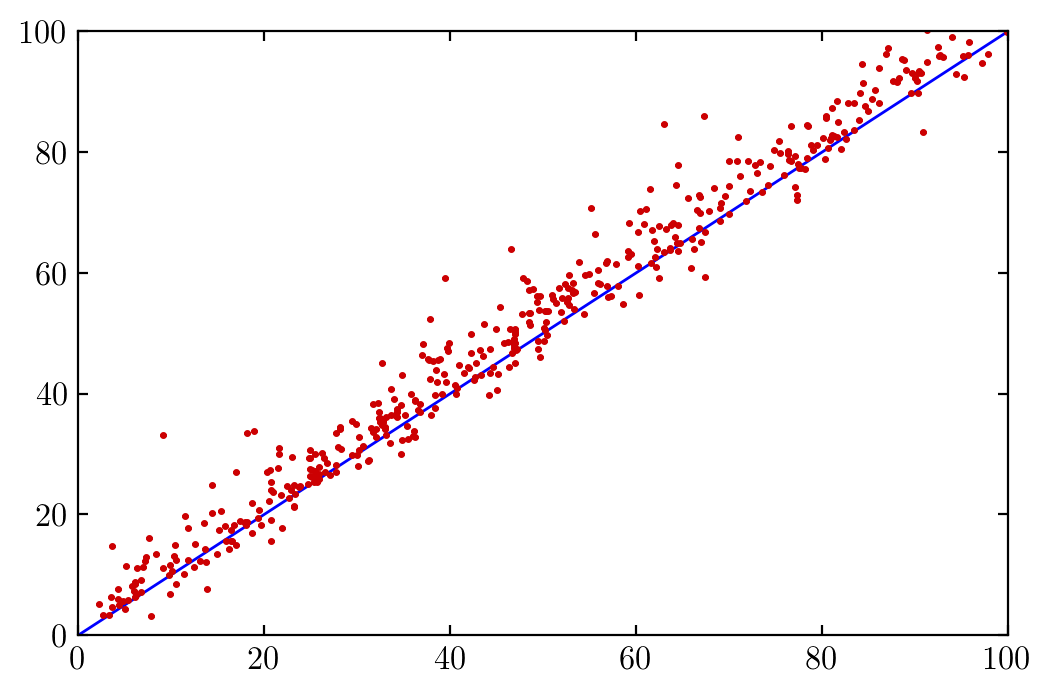

In [108]:
true = test_chi2.flatten()
pred = m.predict(test_samples, kern=m.kern.rbf)
gp = pred[0].flatten()
gp_err = pred[1].flatten()

#gp, gp_err = [-lnprob(i) for i in test_samples], 0

lim = 1e2
_, ax = plt.subplots()
ax.errorbar(true, gp+np.sqrt(gp_err), yerr=0, ls="", marker=".")
ax.plot([0, lim], [0, lim])
ax.set(xlim=(0, lim), ylim=(0, lim))

## MCMC

In [136]:
# Return the lnprob that we have better than 1sigma confidence in
# We do this rather than the mean so that far away points are discouraged.
def lnprob(x):
    if np.all(x > ranges[:,0]) and np.all(x < ranges[:,1]):
        pred = m.predict(x.reshape((1, -1)), kern=m.kern.rbf)
        return -(pred[0][0][0] + np.sqrt(pred[1][0][0]))
    else:
        return -1e20

ndim, nwalkers = 7, 20

# Start in good positions
p0 = test_samples[np.argsort(test_chi2.flatten())][:nwalkers]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [137]:
pos, prob, state = sampler.run_mcmc(p0, 20)
sampler.reset()

In [138]:
sampler.run_mcmc(pos, 100);

In [163]:
sampler.run_mcmc(None, 10000);

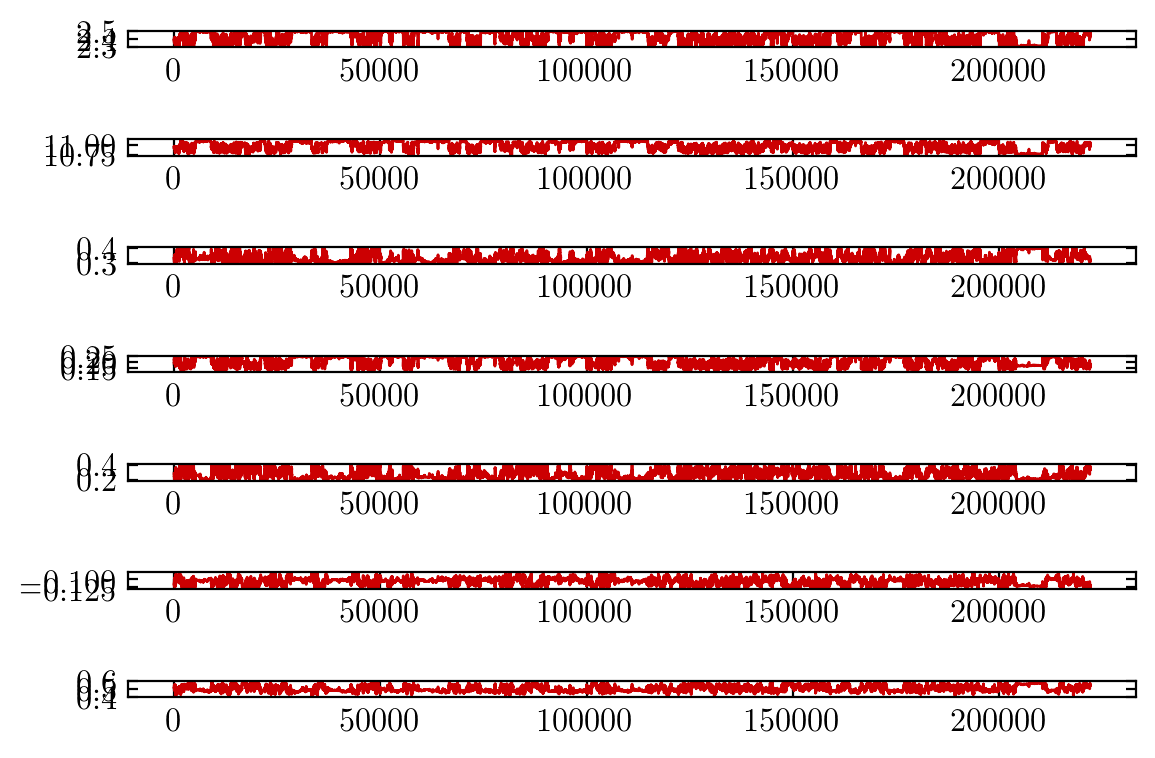

In [145]:
_, axes = plt.subplots(7, 1)
for i in range(ndim):
    axes[i].plot(sampler.flatchain[:,i])
plt.tight_layout()

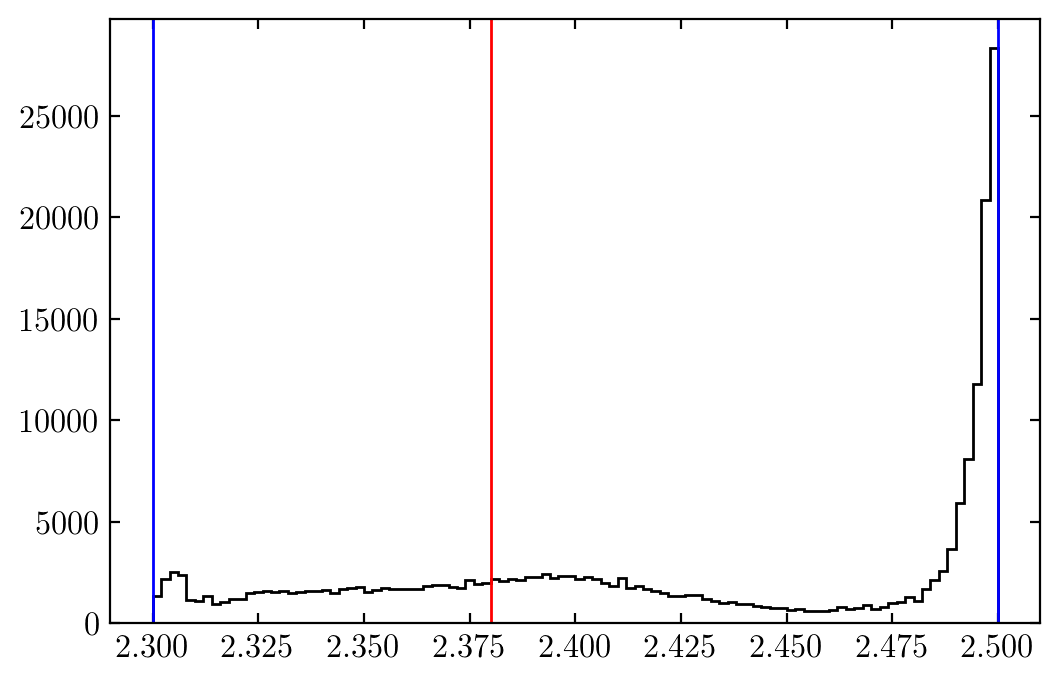

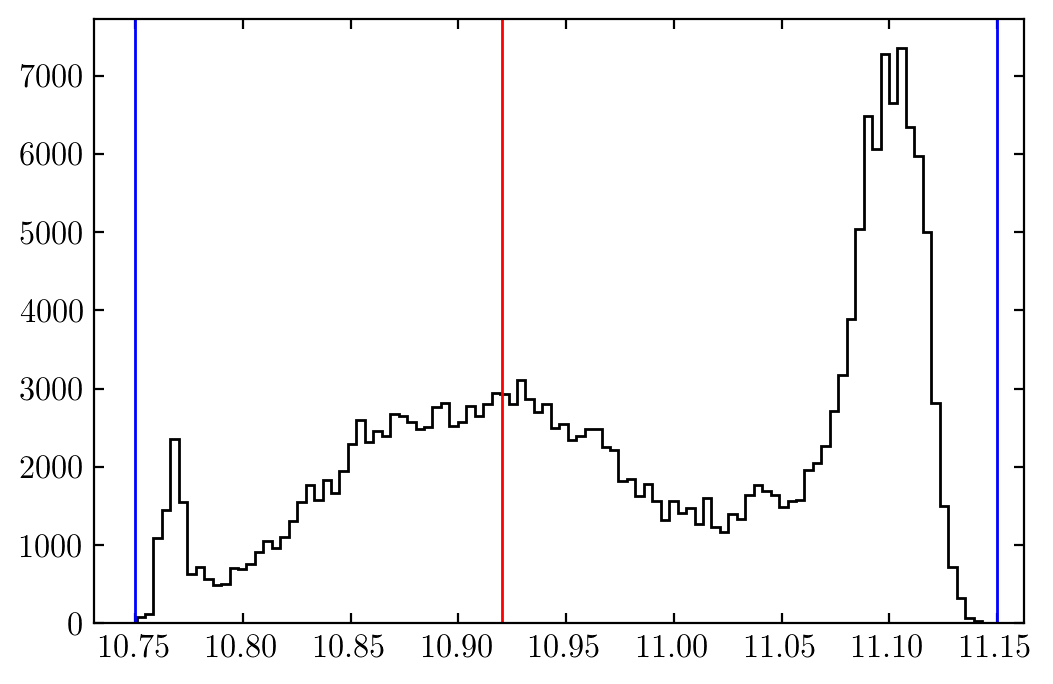

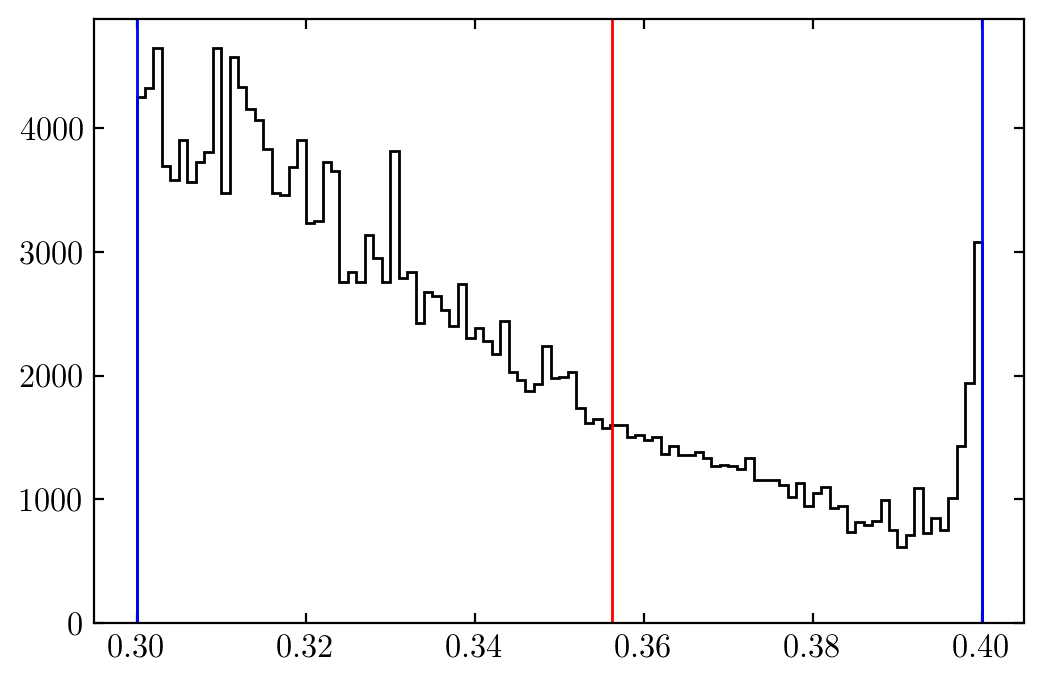

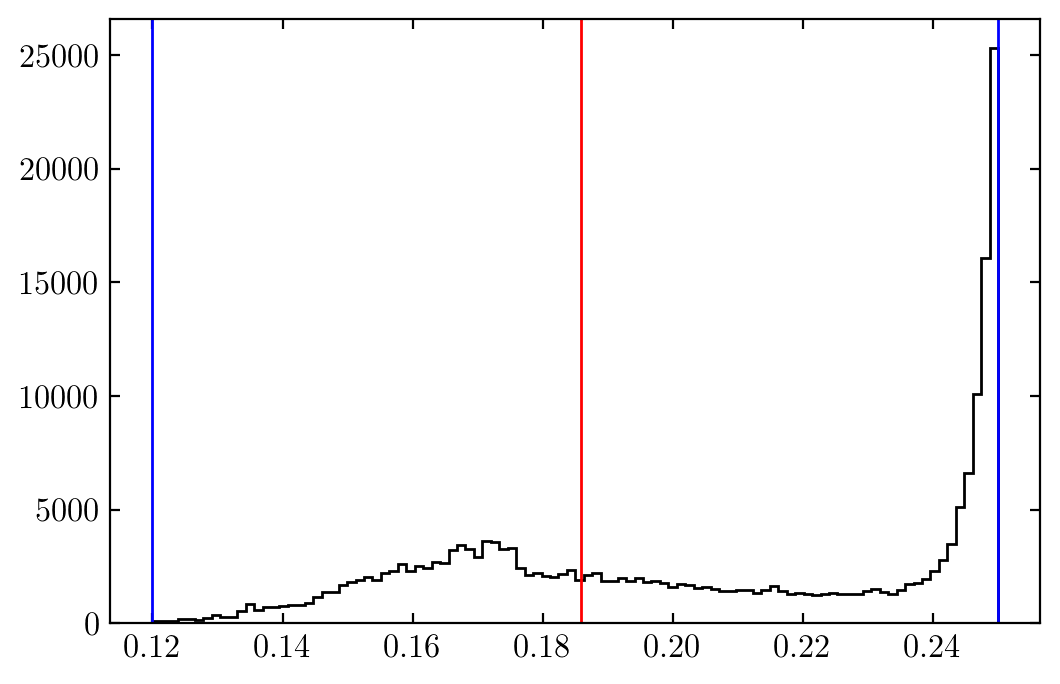

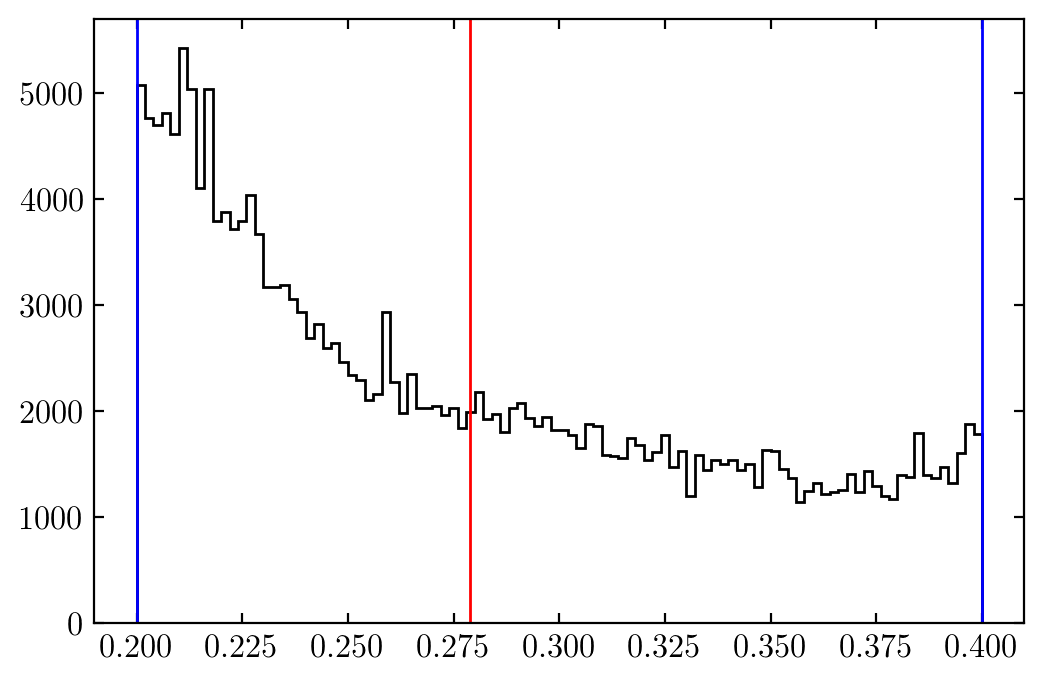

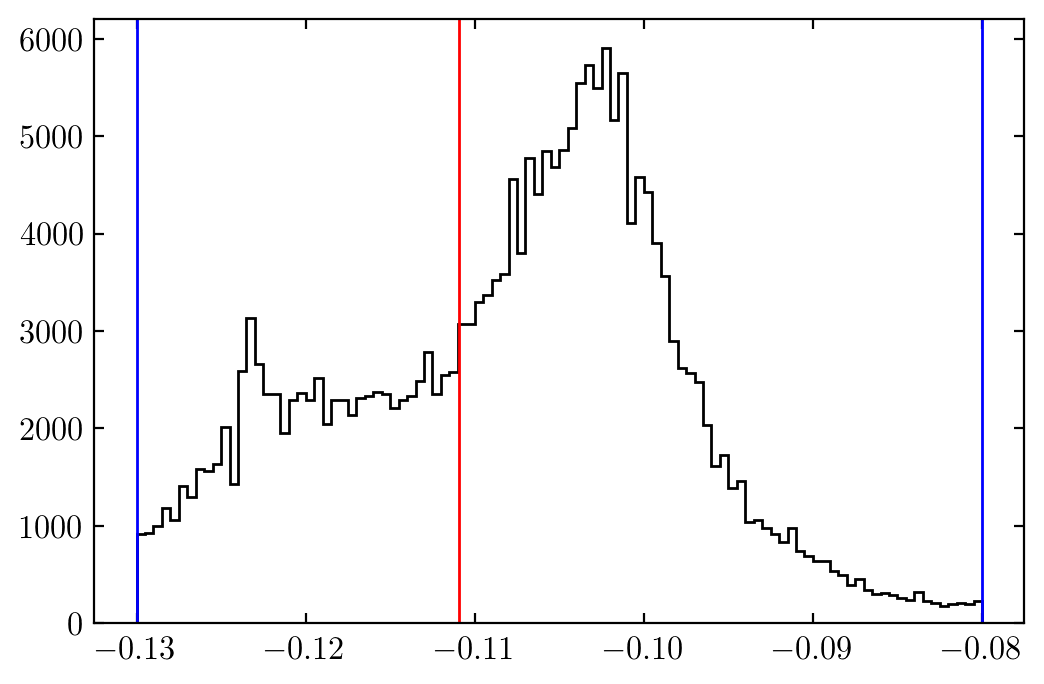

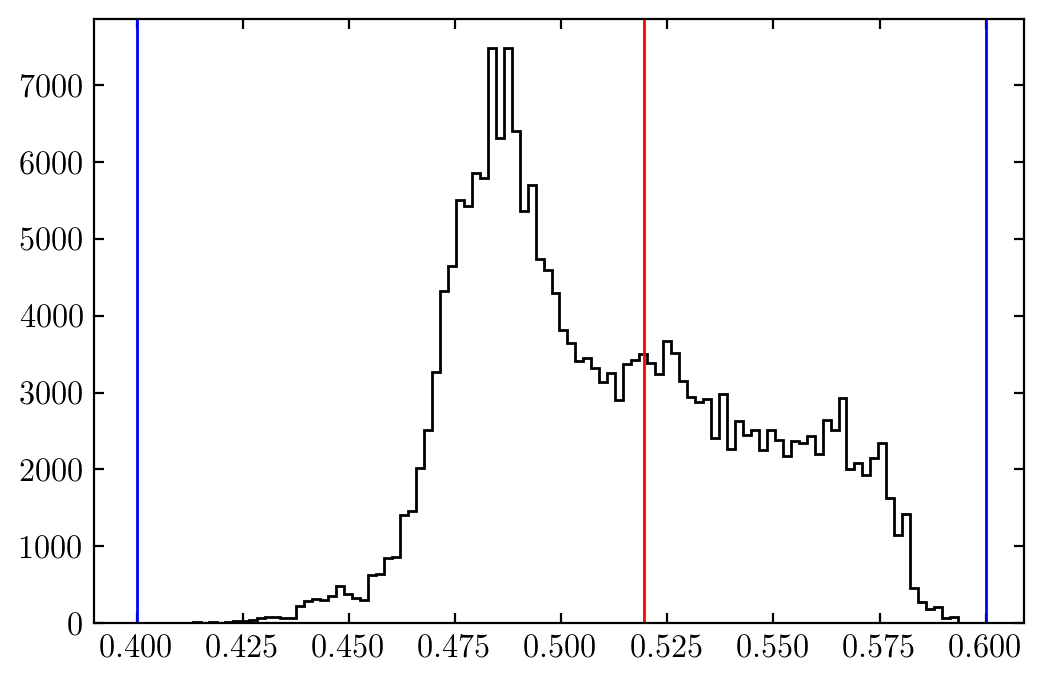

In [146]:
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    ax.axvline(best_fit[i], color="r")
    ax.axvline(ranges[i,0], color="b")
    ax.axvline(ranges[i,1], color="b")
    #ax.set(xlim=(ranges[i,0], ranges[i,1]))
    #ax.title("Dimension {0:d}".format(i))

In [162]:
# Sanity checks
print("Acceptance fraction should be between 0.25 and 0.5: {}".format(sampler.acceptance_fraction))
print("Total chain length: {}".format(sampler.flatchain.shape[0]))
print(sampler.get_autocorr_time(c=2))

Acceptance fraction should be between 0.25 and 0.5: [0.24018018 0.28324324 0.24018018 0.18630631 0.25081081 0.17144144 0.24864865 0.25027027 0.18153153 0.24576577 0.22288288 0.31306306 0.33144144 0.29576577 0.29099099 0.27135135 0.29540541 0.29963964 0.16225225 0.27234234]
Total chain length: 222000


AutocorrError: The chain is too short to reliably estimate the autocorrelation time

# Build bestfit model and compare to observations

In [163]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)

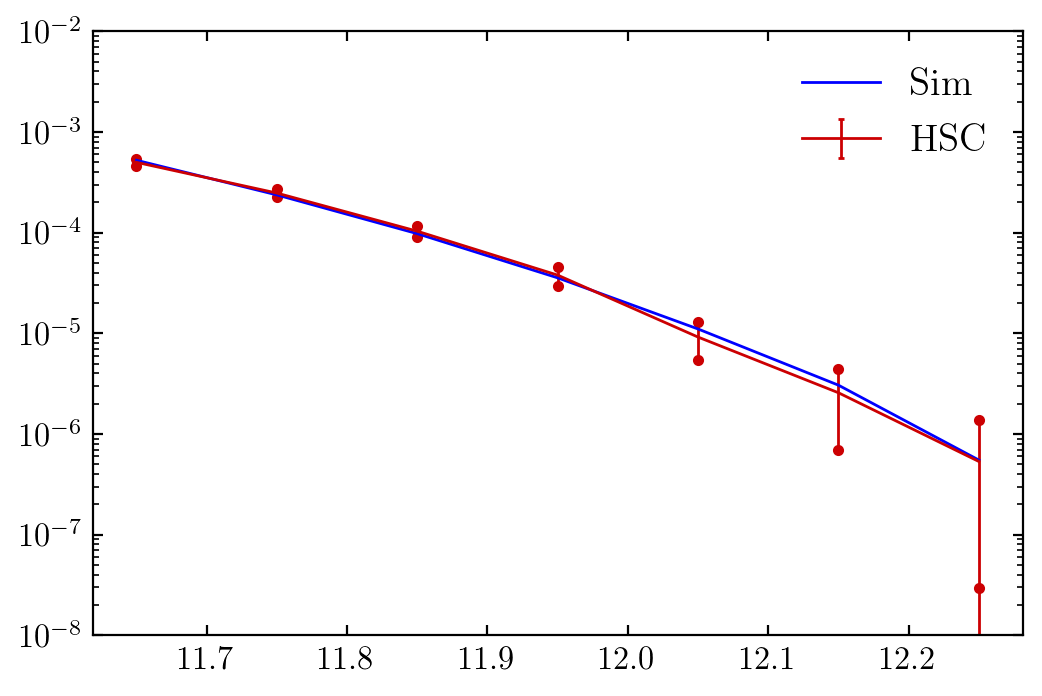

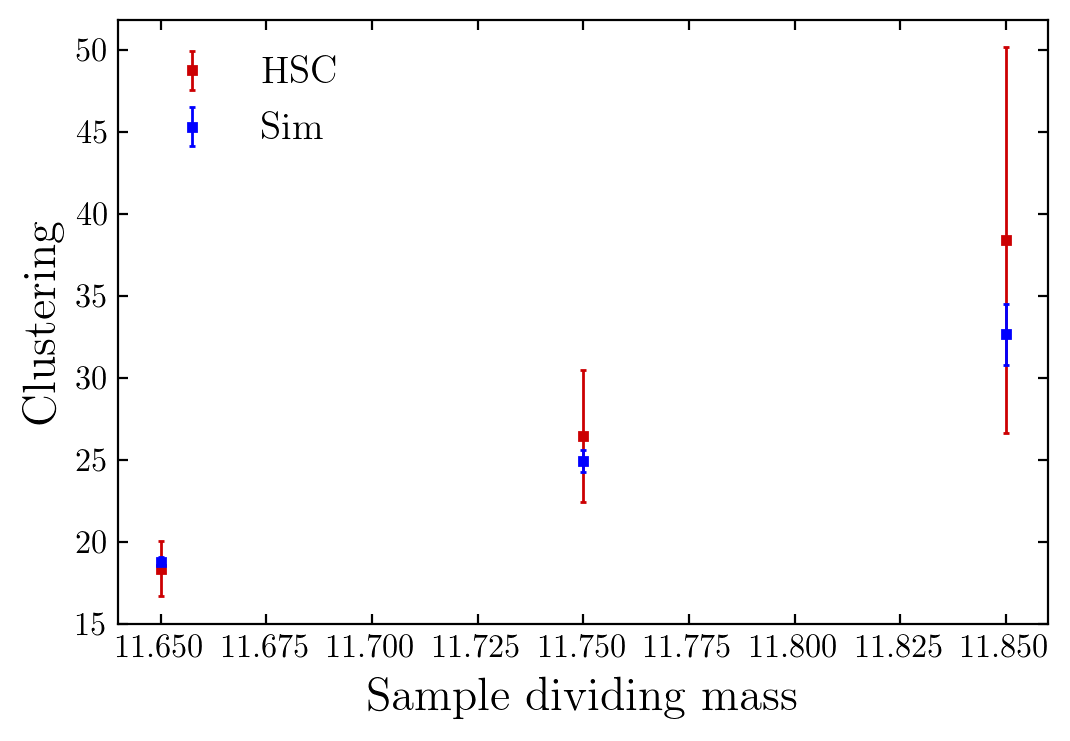

In [183]:
fig, ax = p.plot_smfs(obs_smf, log_stellar_masses, sim_size)
ax.set(ylim=(1e-8, 1e-2));

sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf.png", dpi=300)

fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust.png", dpi=300)

# Save out mock

In [9]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
sim_data_out = np.lib.recfunctions.rename_fields(sim_data_out, {"halo_mvir": "Mpeak"})
np.save("mocks/new", np.ma.getdata(sim_data_out))

# From meeting

In [1]:
sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

NameError: name 'np' is not defined